In [293]:
import numpy as np
from scipy.optimize import curve_fit
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [294]:
SAVE_FILE = False
MAKE_GRAPHS_A = True
MAKE_GRAPHS_B = True

In [295]:
summary_statistics = pd.DataFrame()
# Add columns for SSE1 and SSE2
summary_statistics['SSE1'] = np.nan
summary_statistics['SSE2'] = np.nan

In [296]:
tasks = [
    "square_D1",
    "nut_assembly_D0",
    "three_piece_assembly_D1",
    "kitchen_D1",
    "coffee_D1",
    "stack_three_D1",
    "stack_D0", # Outlier alert!! Try other D0 tasks.
    "hammer_cleanup_D0",
    "pick_place_D0",
    "coffee_preparation_D1",
    "mug_cleanup_D1",
    "threading_D2",
    
    "Cumulative_Data",
]

trial_count = 30

fit_type = "sigmoid" # sigmoid, arctan

In [297]:
def sigmoid(x,A,B,C,E,P=0,Q=0):
    Offset = 0 if P==0 else 2*P-A
    return A / (B + np.exp(-C * x - E)) + A + Offset

def arctan(x,A,B,C,E,P=0,Q=0):
    Offset = A if P==0 else P
    return A * np.arctan(B * x - C) + E + Offset

chosen_function, initial_guess, param_bounds = None,None,None
if fit_type == "sigmoid":
    chosen_function = sigmoid
    initial_guess = [-52.8,1.0,17.6,-3.32]
    param_bounds = (
        [-100, 0.01, 0.01, -10],   # Lower bounds: [A, B, C, D, E]
        [100, 10, 100, 10]          # Upper bounds
    )
elif fit_type == "arctan":
    chosen_function = arctan
    initial_guess = [-25,10,3.1,37.5]
    param_bounds = ([-100, 5, 0.01, 20],
        [0, 20, 100, 60])

Parameters for task square_D1: [-45.83135873   0.97421068  11.32216409  -2.71064877]
Performance with 0 noise: 42
SSE: 267.62280160734076


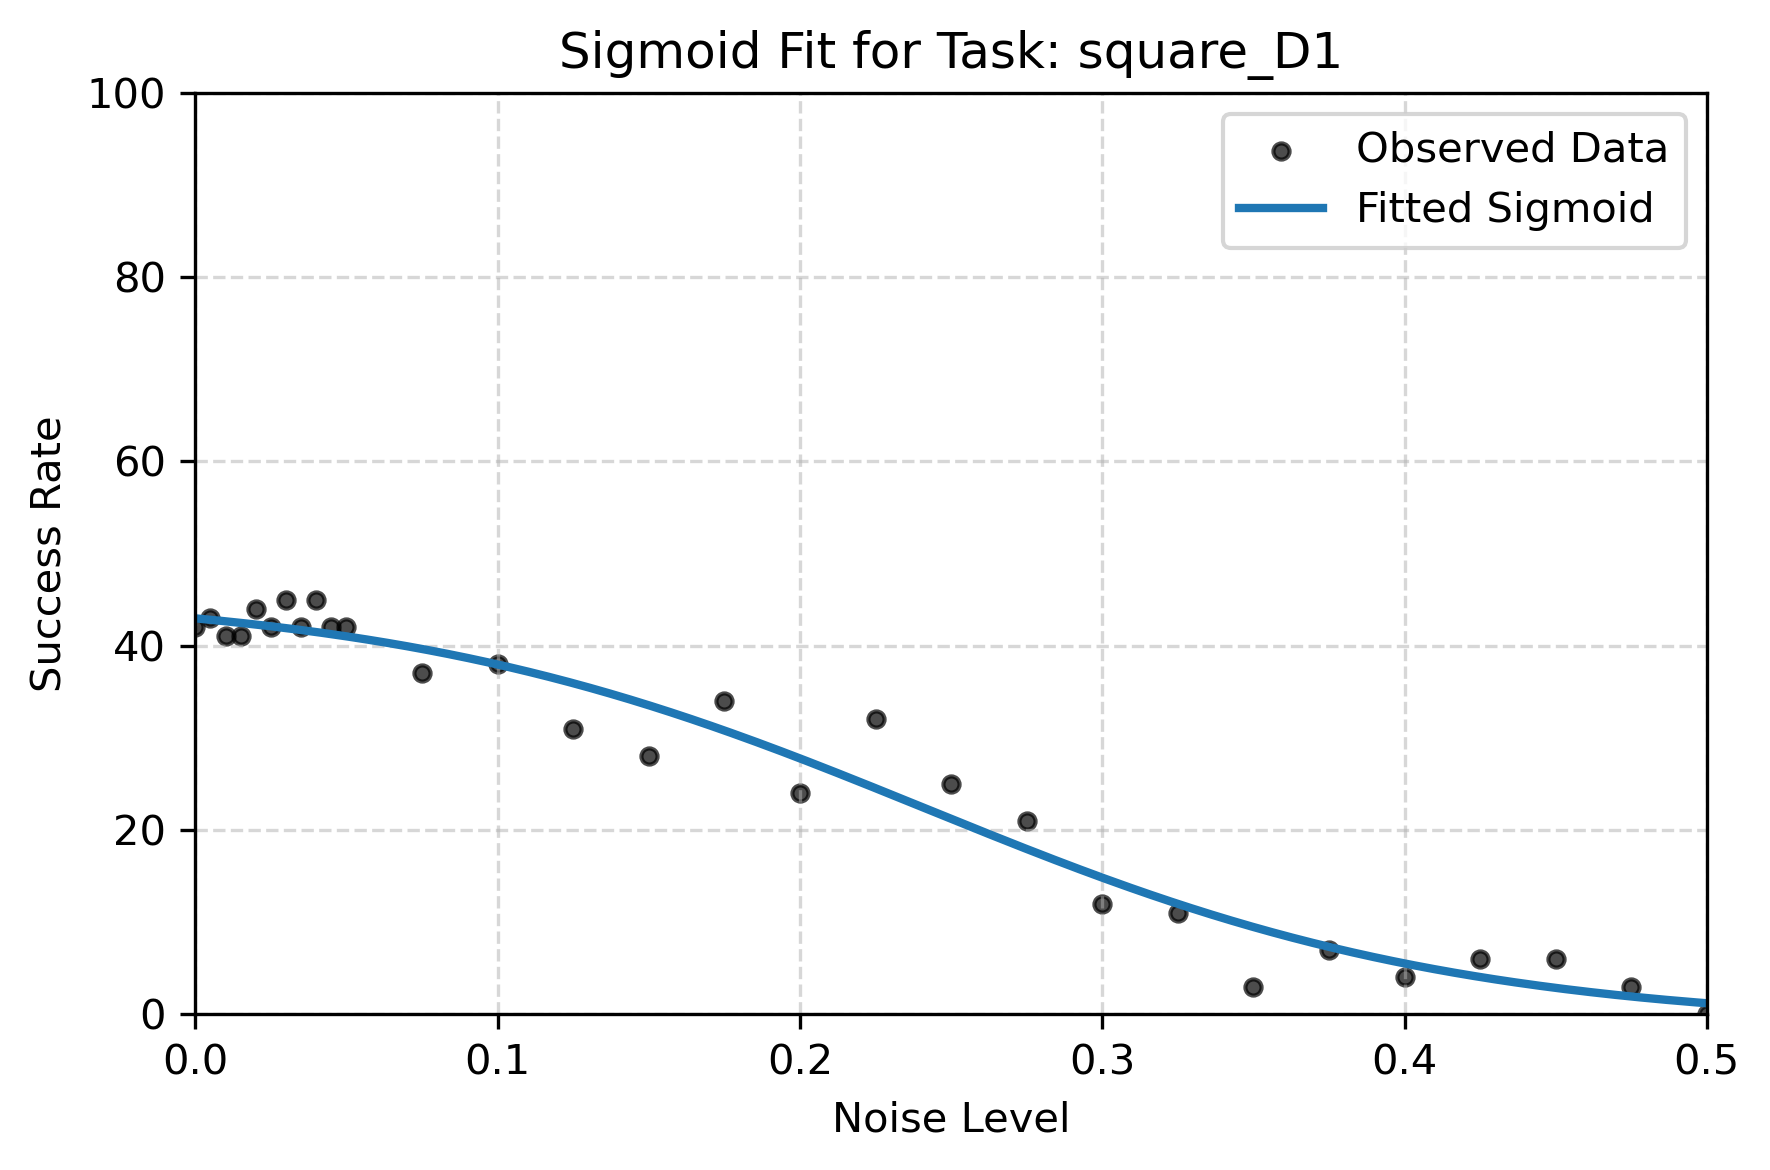

Parameters for task nut_assembly_D0: [-54.75704451   1.00332824  20.30502194  -3.62992183]
Performance with 0 noise: 53
SSE: 279.67001179611674


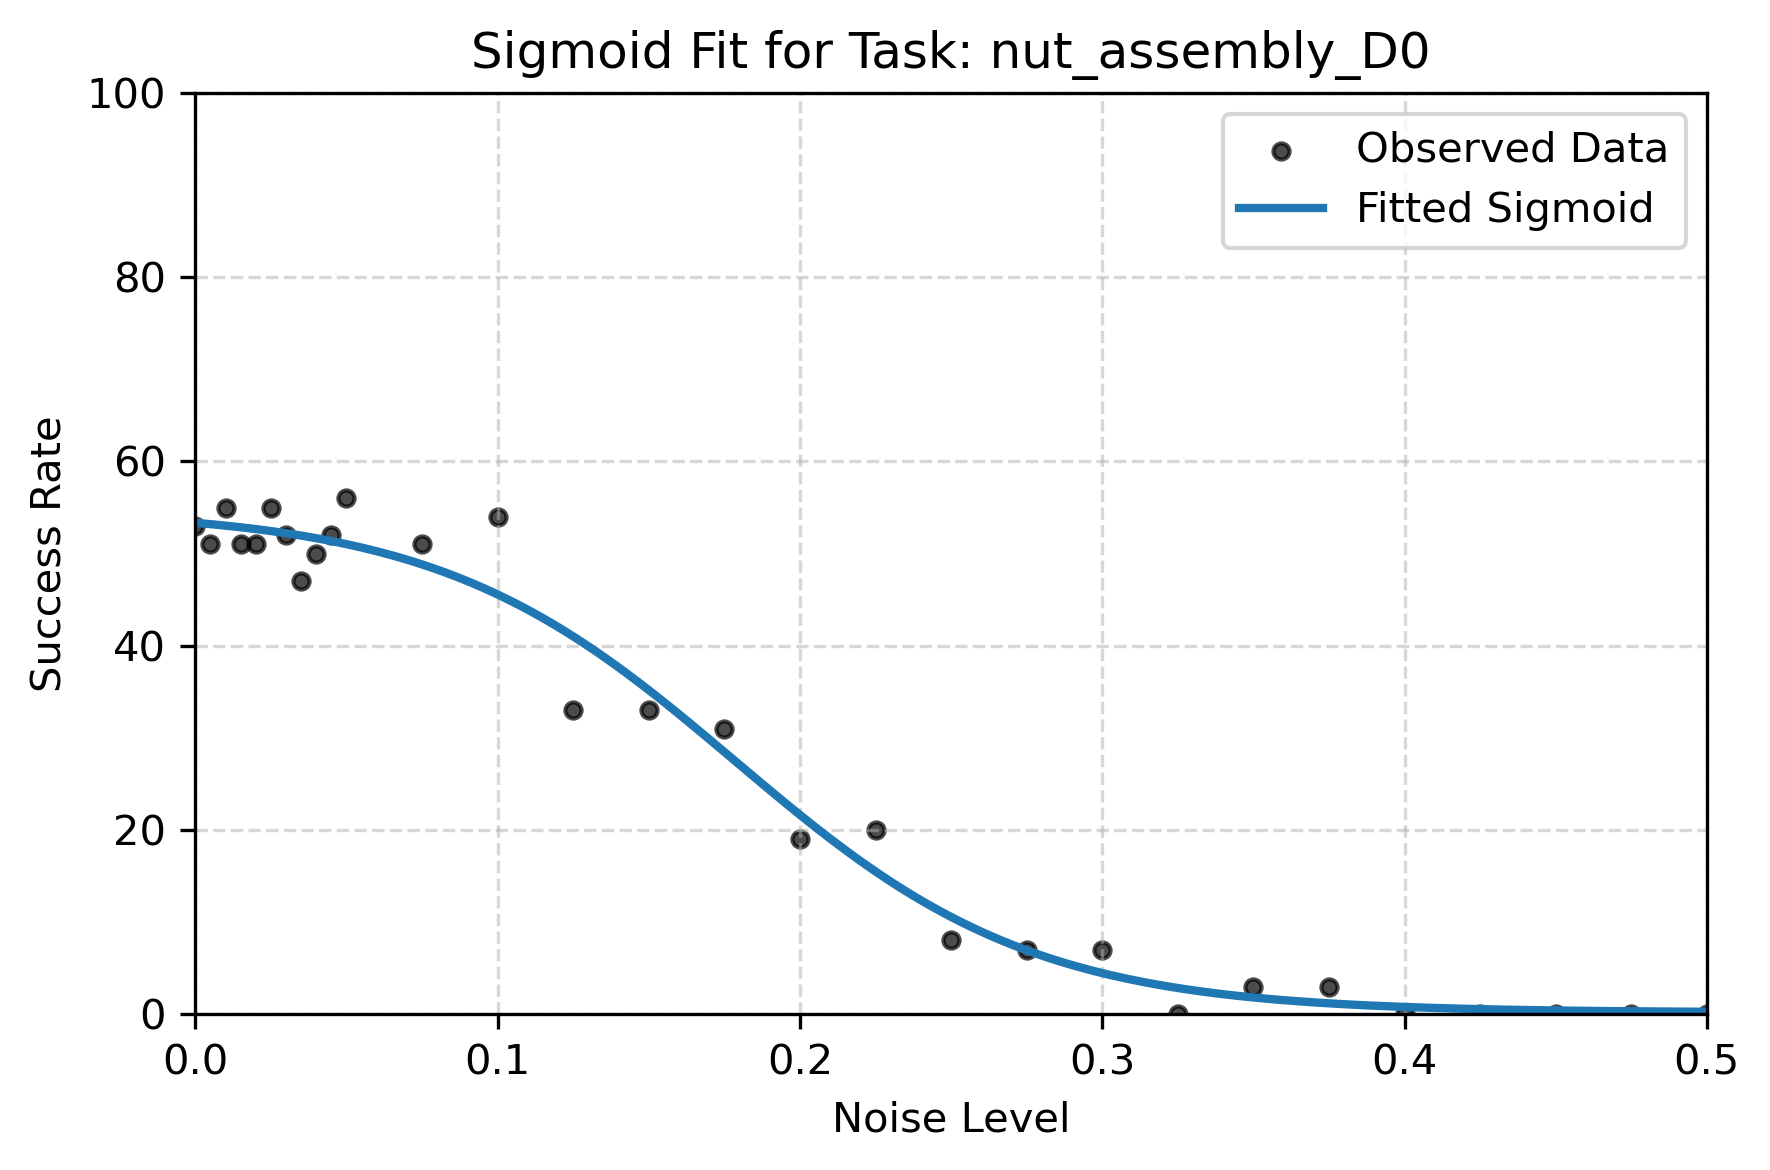

Parameters for task three_piece_assembly_D1: [-26.30720954   1.02556998  19.2958359   -3.43661591]
Performance with 0 noise: 23
SSE: 145.06772798224358


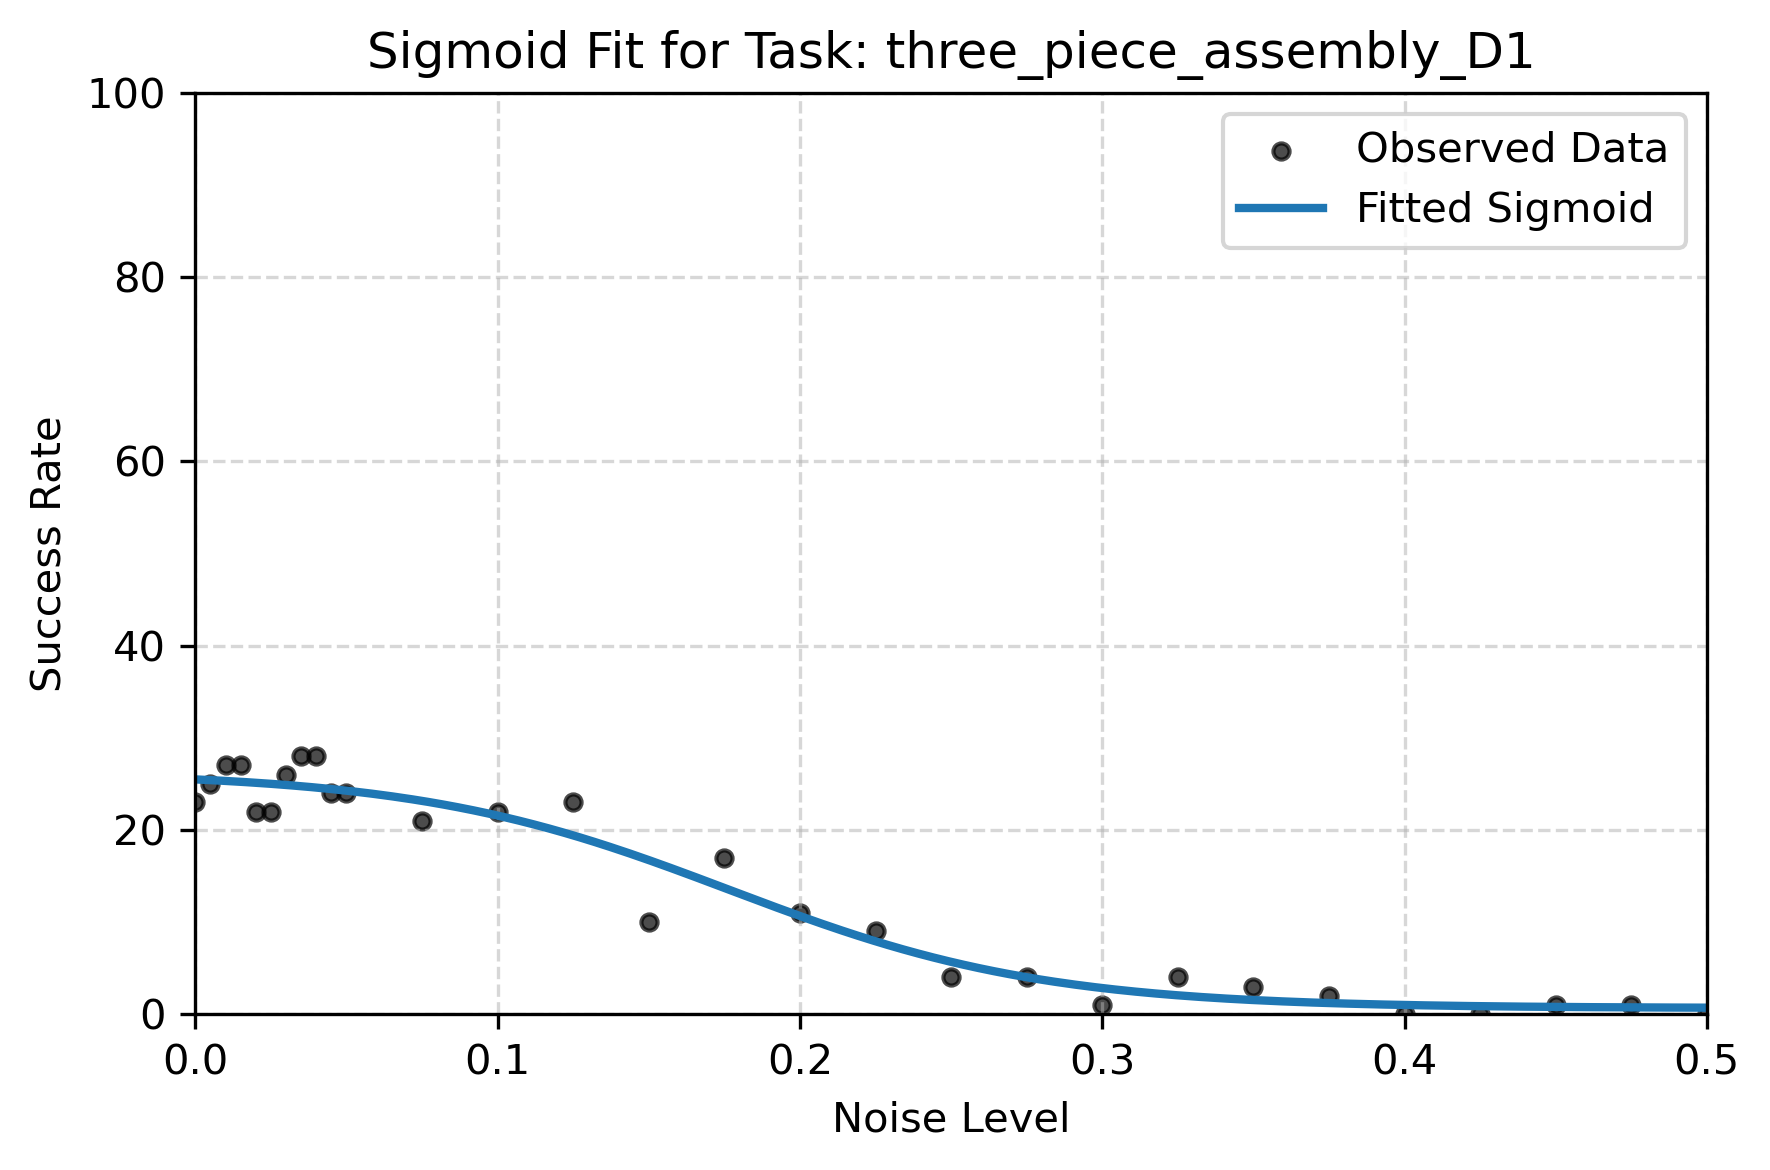

Parameters for task kitchen_D1: [-53.08434461   0.99533897  16.50924791  -3.33916615]
Performance with 0 noise: 52
SSE: 361.9060331874671


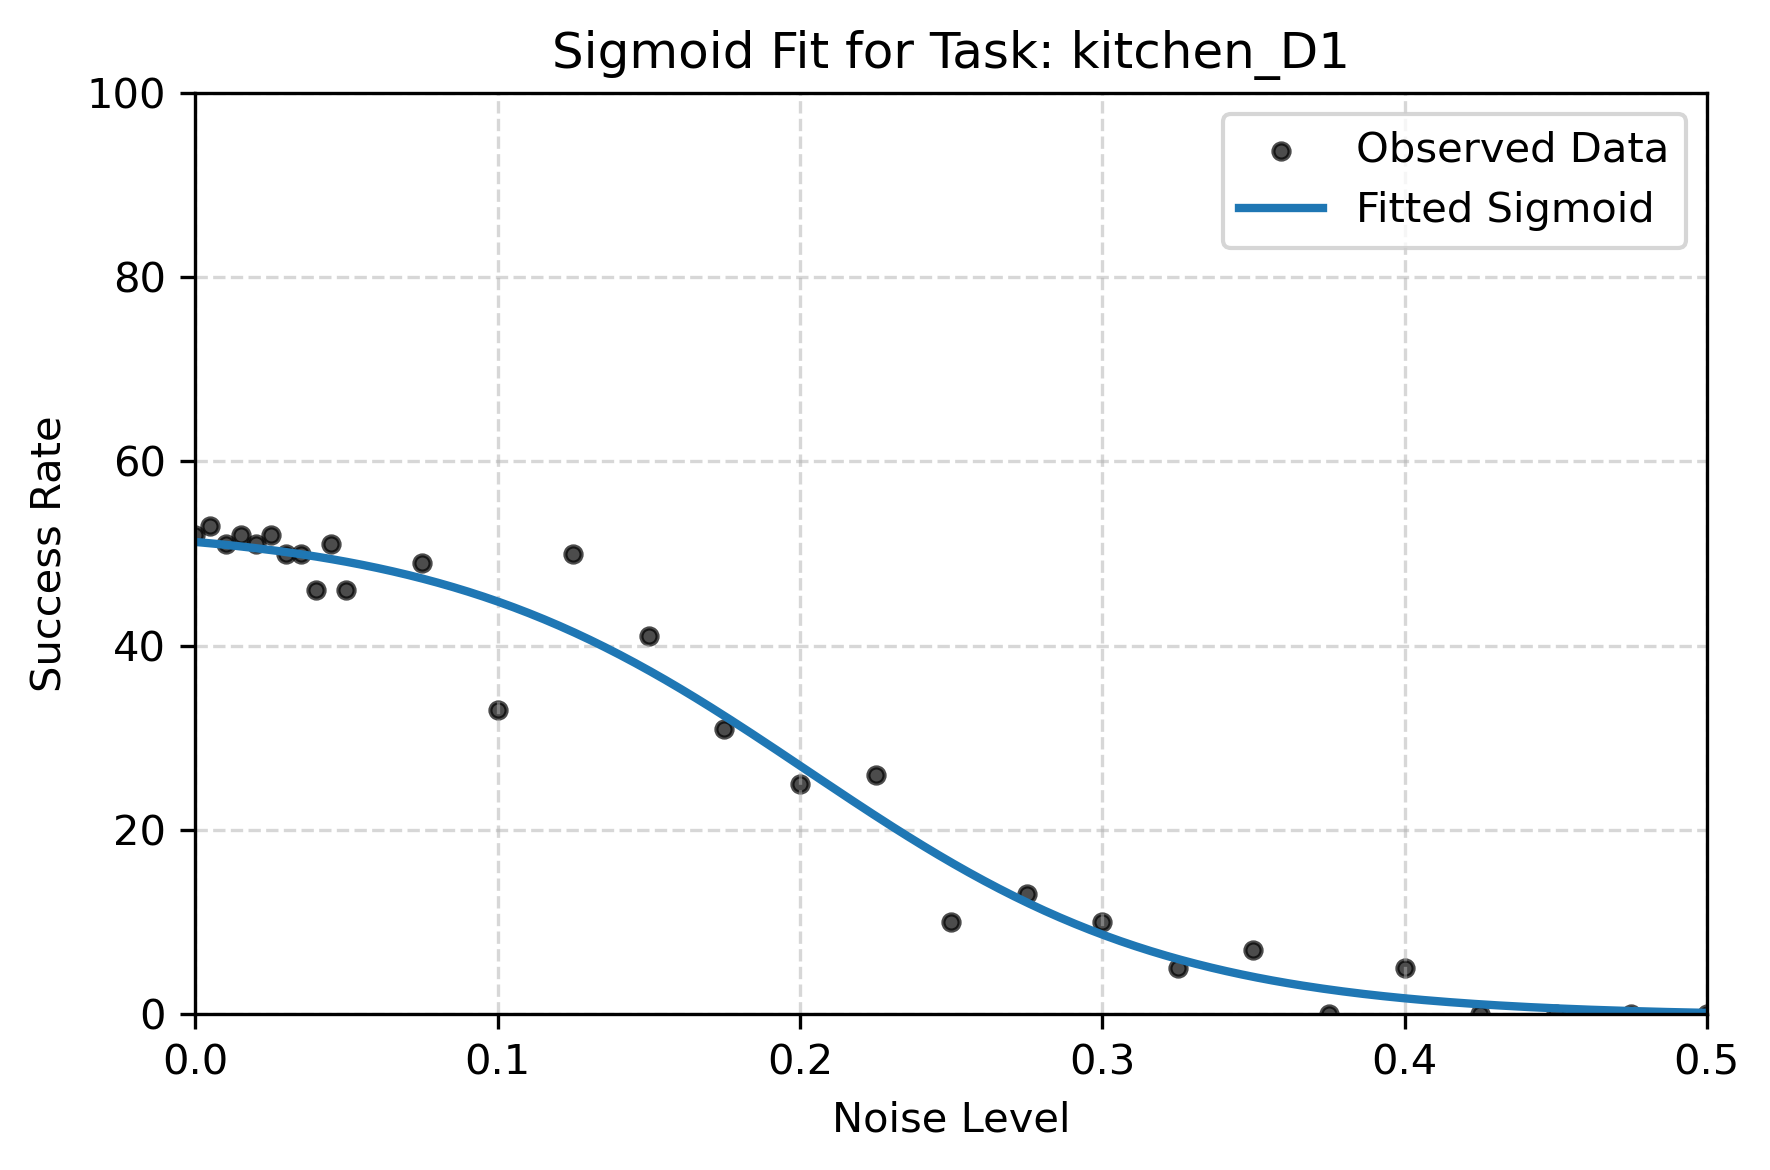

Parameters for task coffee_D1: [-67.15032877   0.99359083  20.02083817  -3.13311204]
Performance with 0 noise: 65
SSE: 354.3258083440832


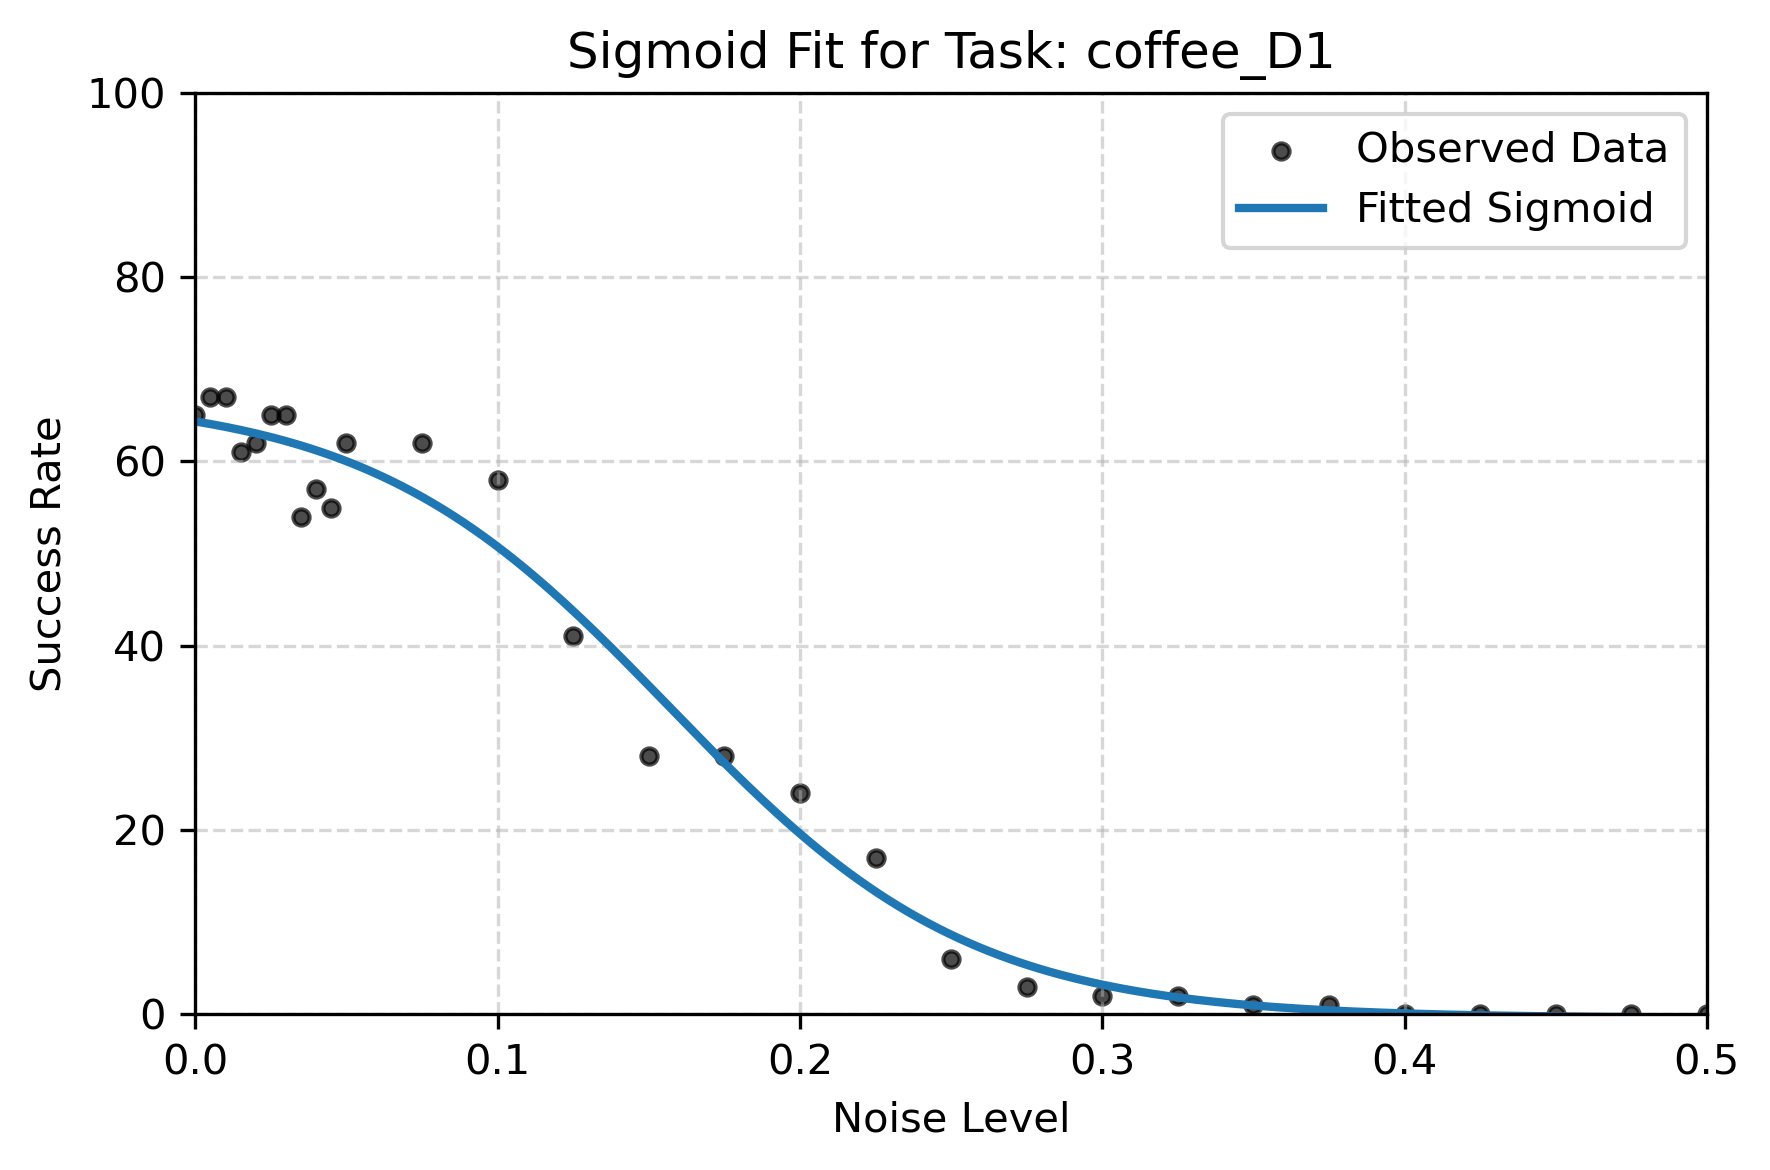

Parameters for task stack_three_D1: [-72.21069965   1.0401792   18.9806884   -3.57712528]
Performance with 0 noise: 68
SSE: 336.95791414158595


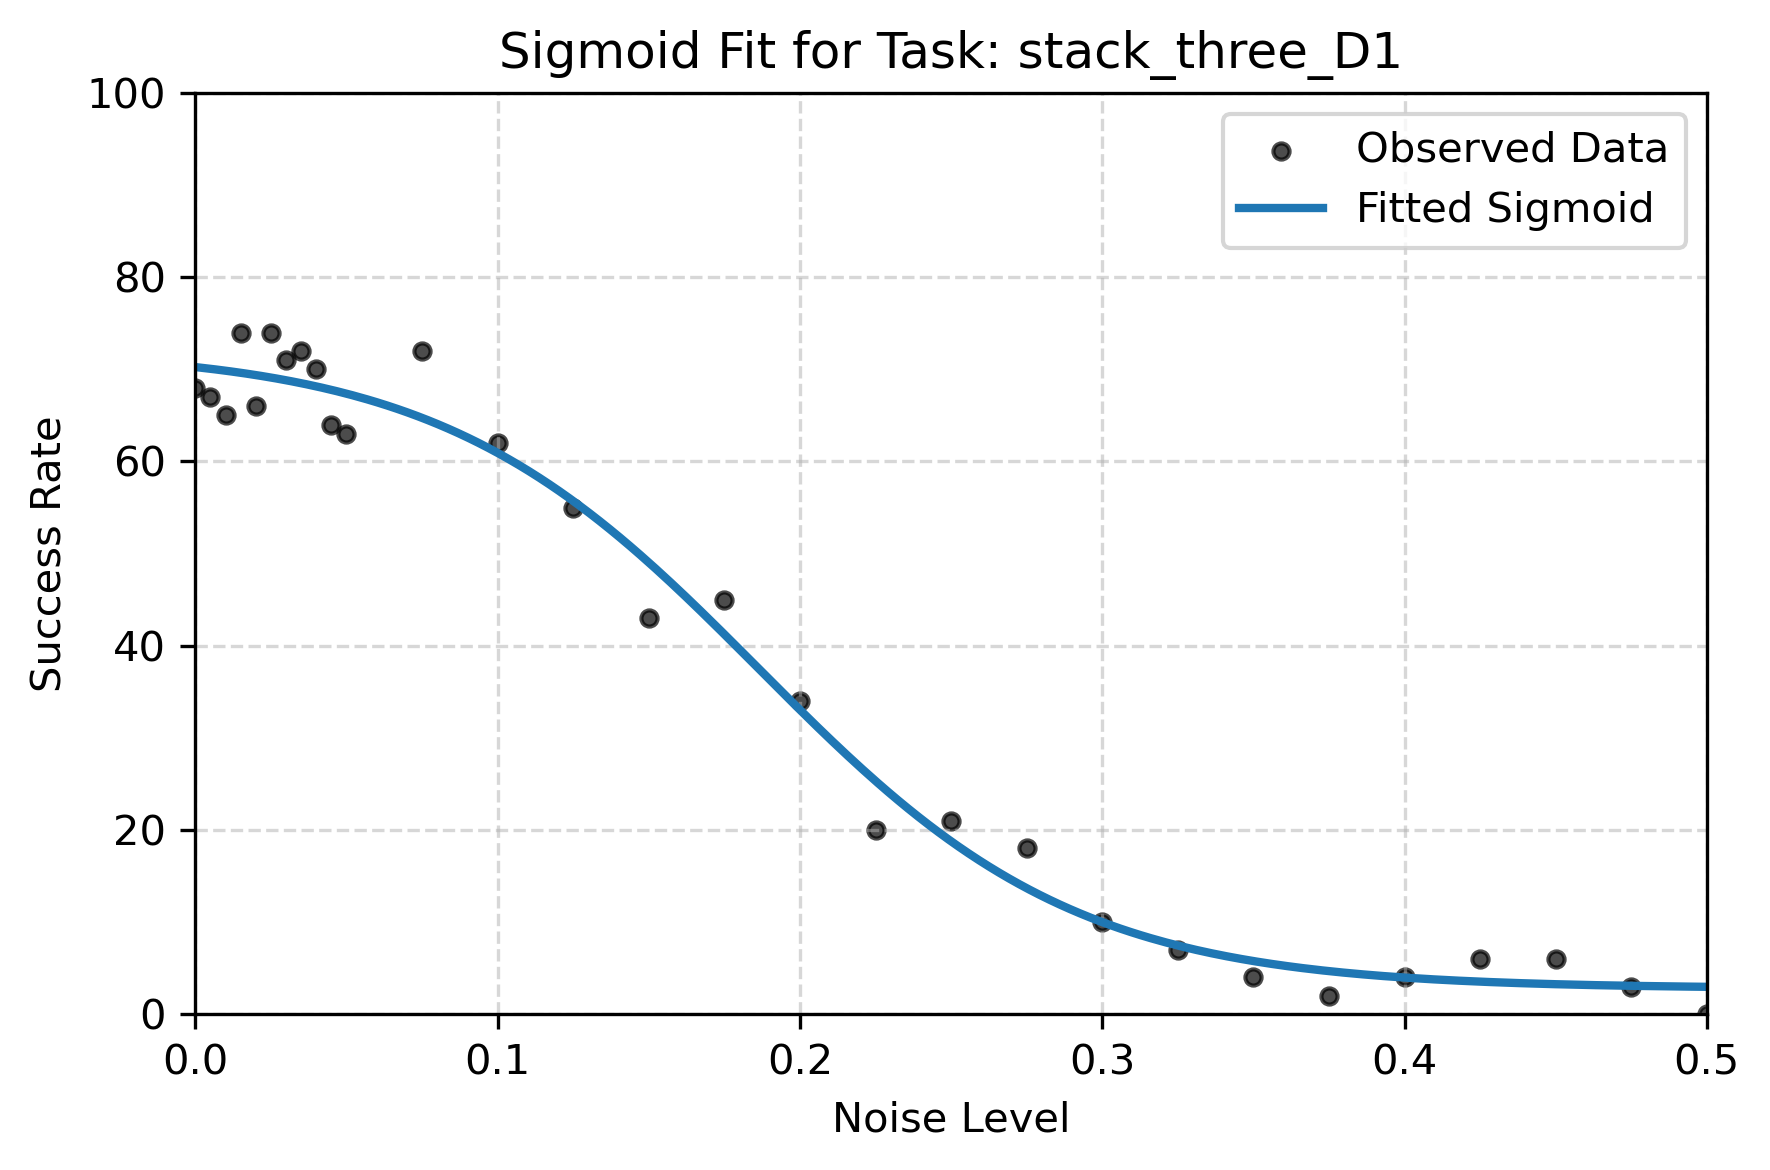

Parameters for task stack_D0: [-95.93540415   1.2372783   16.52325602  -5.77708881]
Performance with 0 noise: 93
SSE: 183.95122563748907


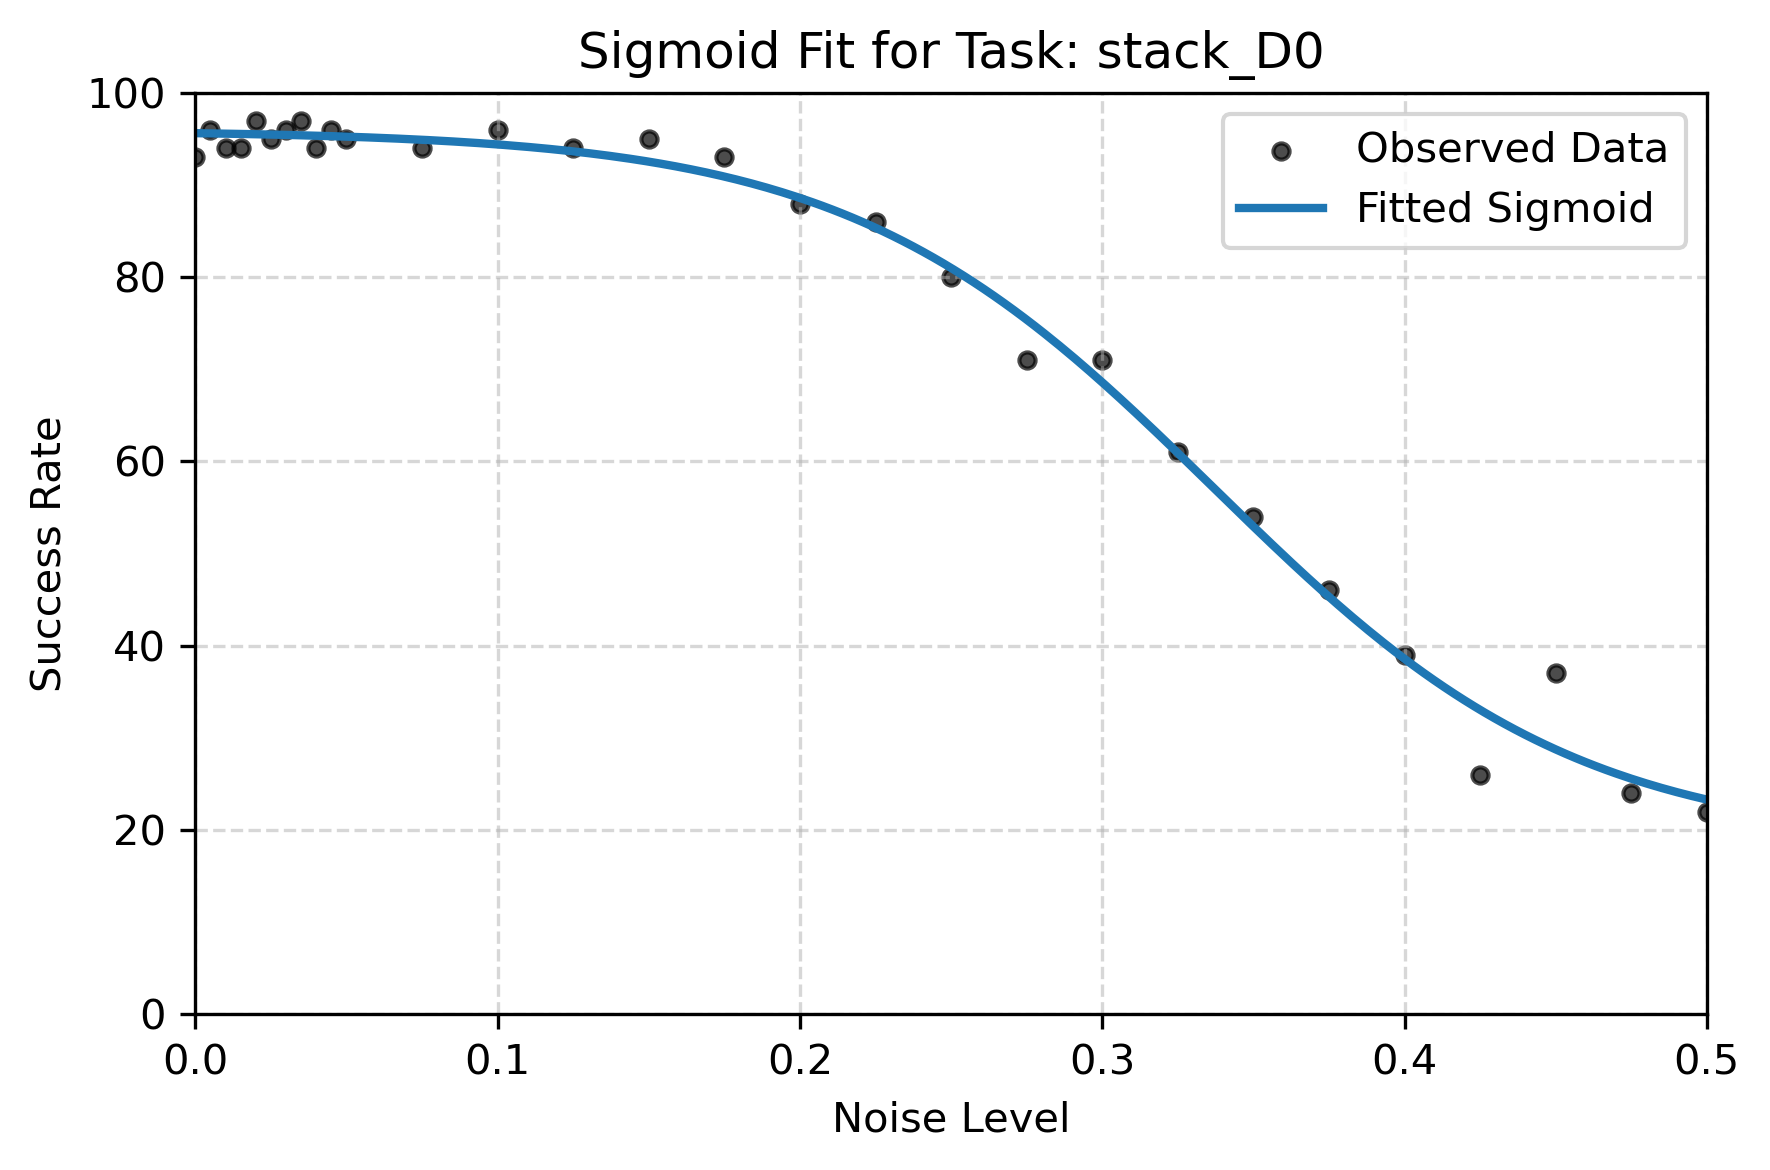

Parameters for task hammer_cleanup_D0: [-44.11827881   0.99237036  18.38165618  -4.4017922 ]
Performance with 0 noise: 43
SSE: 51.38491239307436


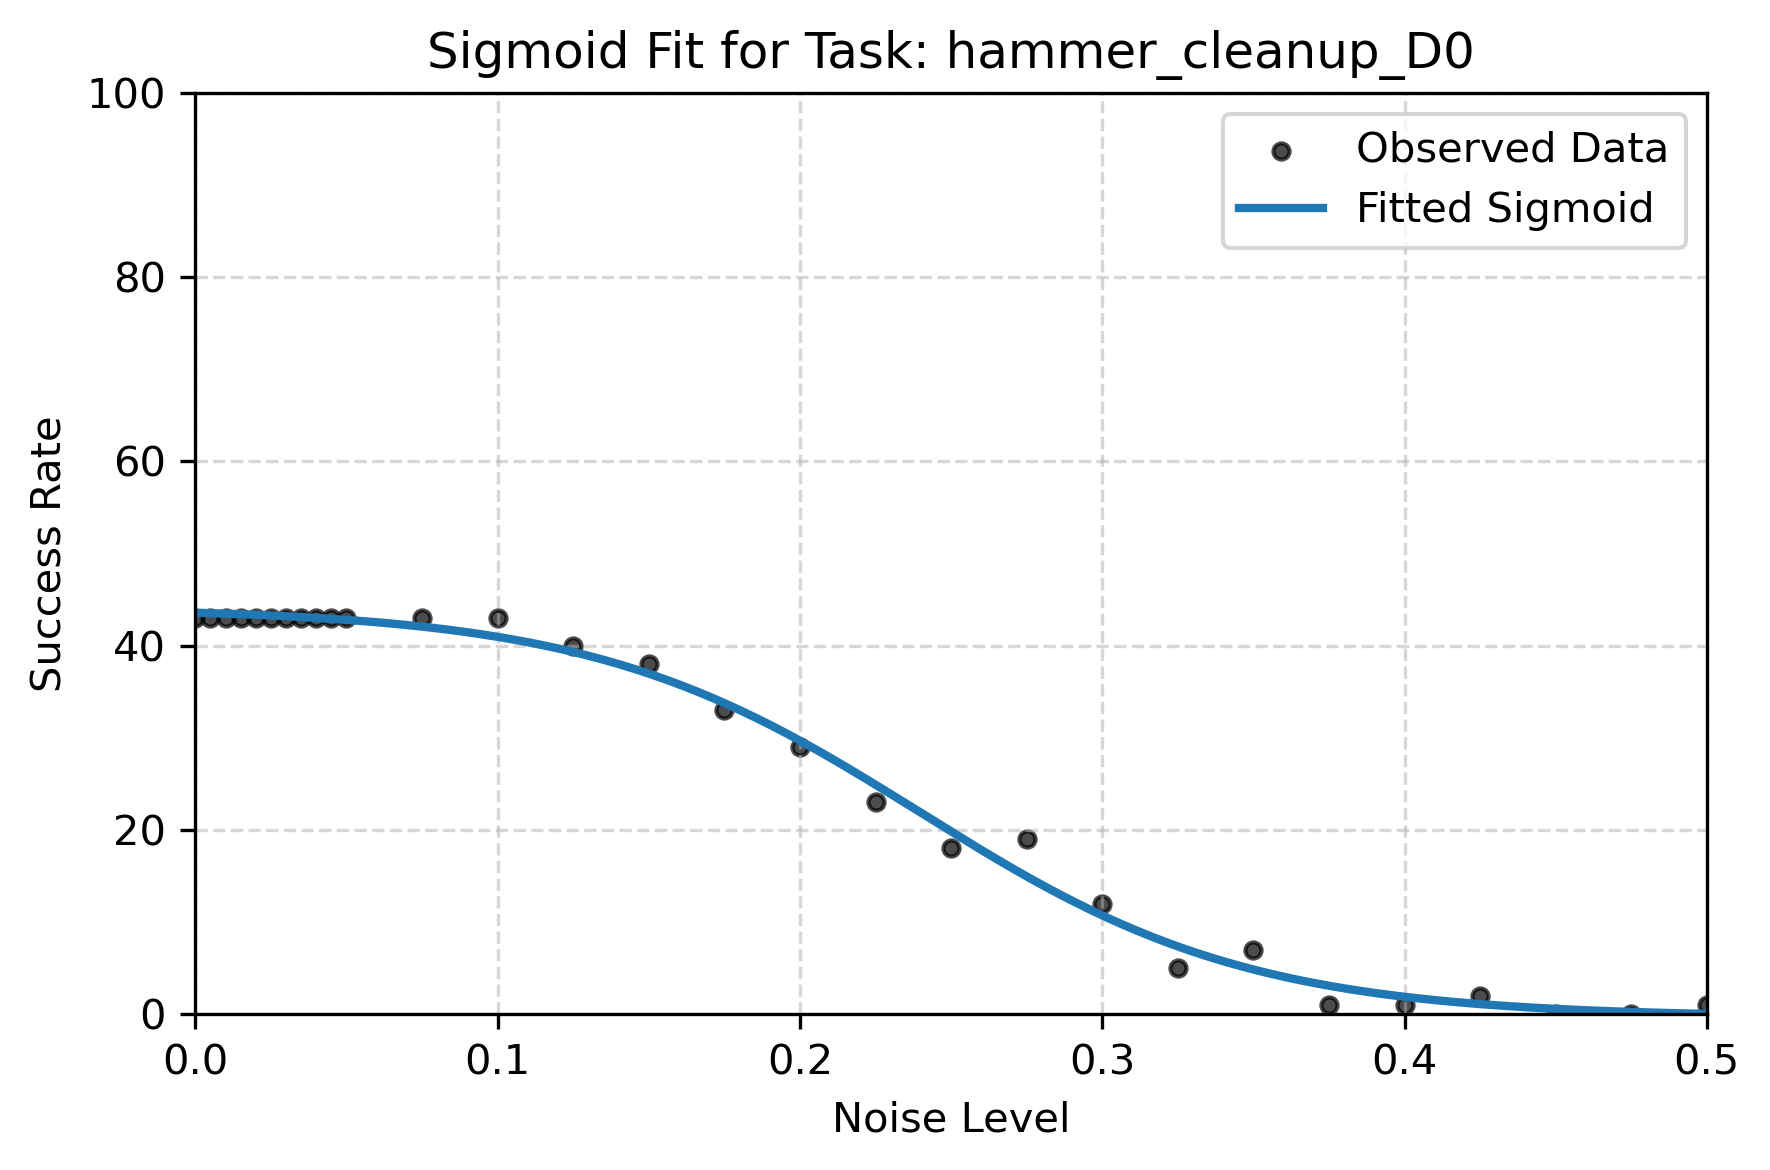

Parameters for task pick_place_D0: [-35.18967416   1.00734129  29.74014514  -3.97685795]
Performance with 0 noise: 39
SSE: 264.11606714681494


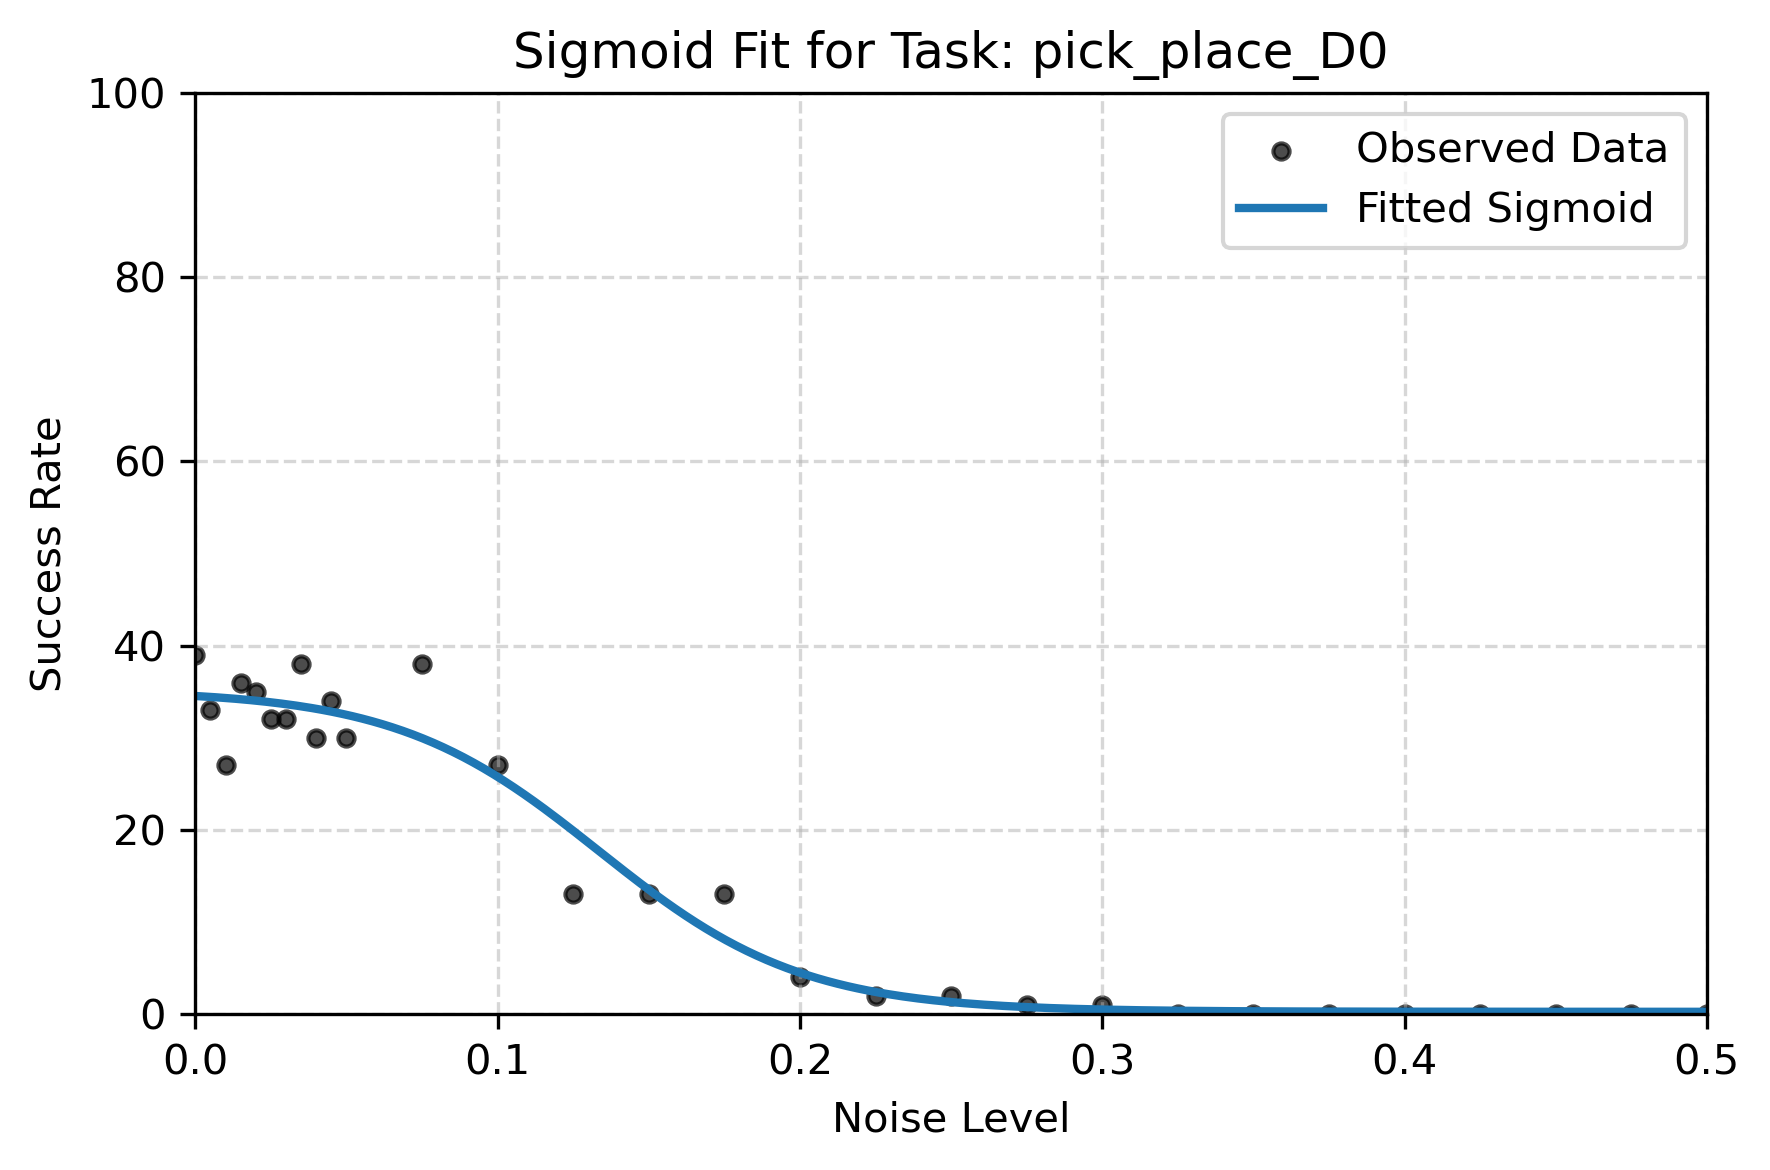

Parameters for task coffee_preparation_D1: [-40.29059807   0.99154813  25.03428828  -3.21550597]
Performance with 0 noise: 40
SSE: 113.67216580087997


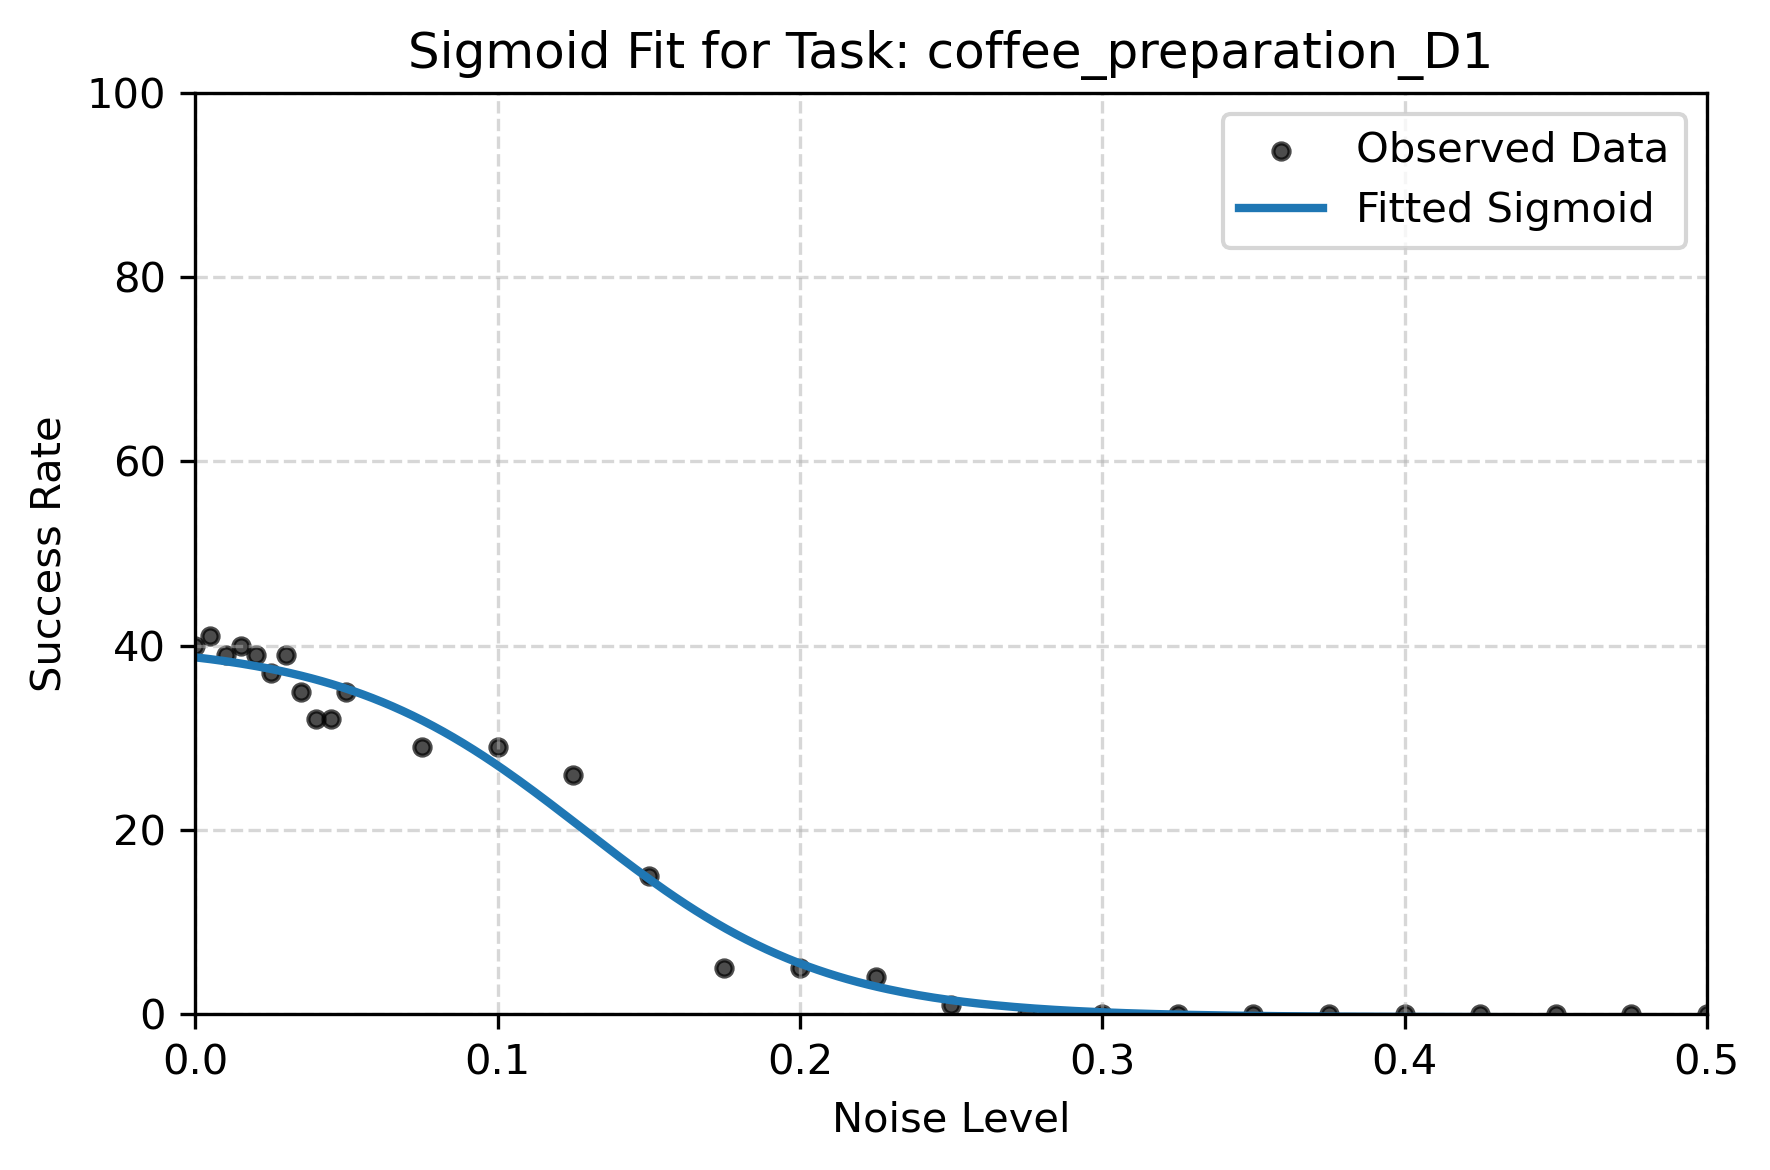

Parameters for task mug_cleanup_D1: [-26.40448314   0.97124104  15.0864852   -3.6891901 ]
Performance with 0 noise: 26
SSE: 122.49291078664429


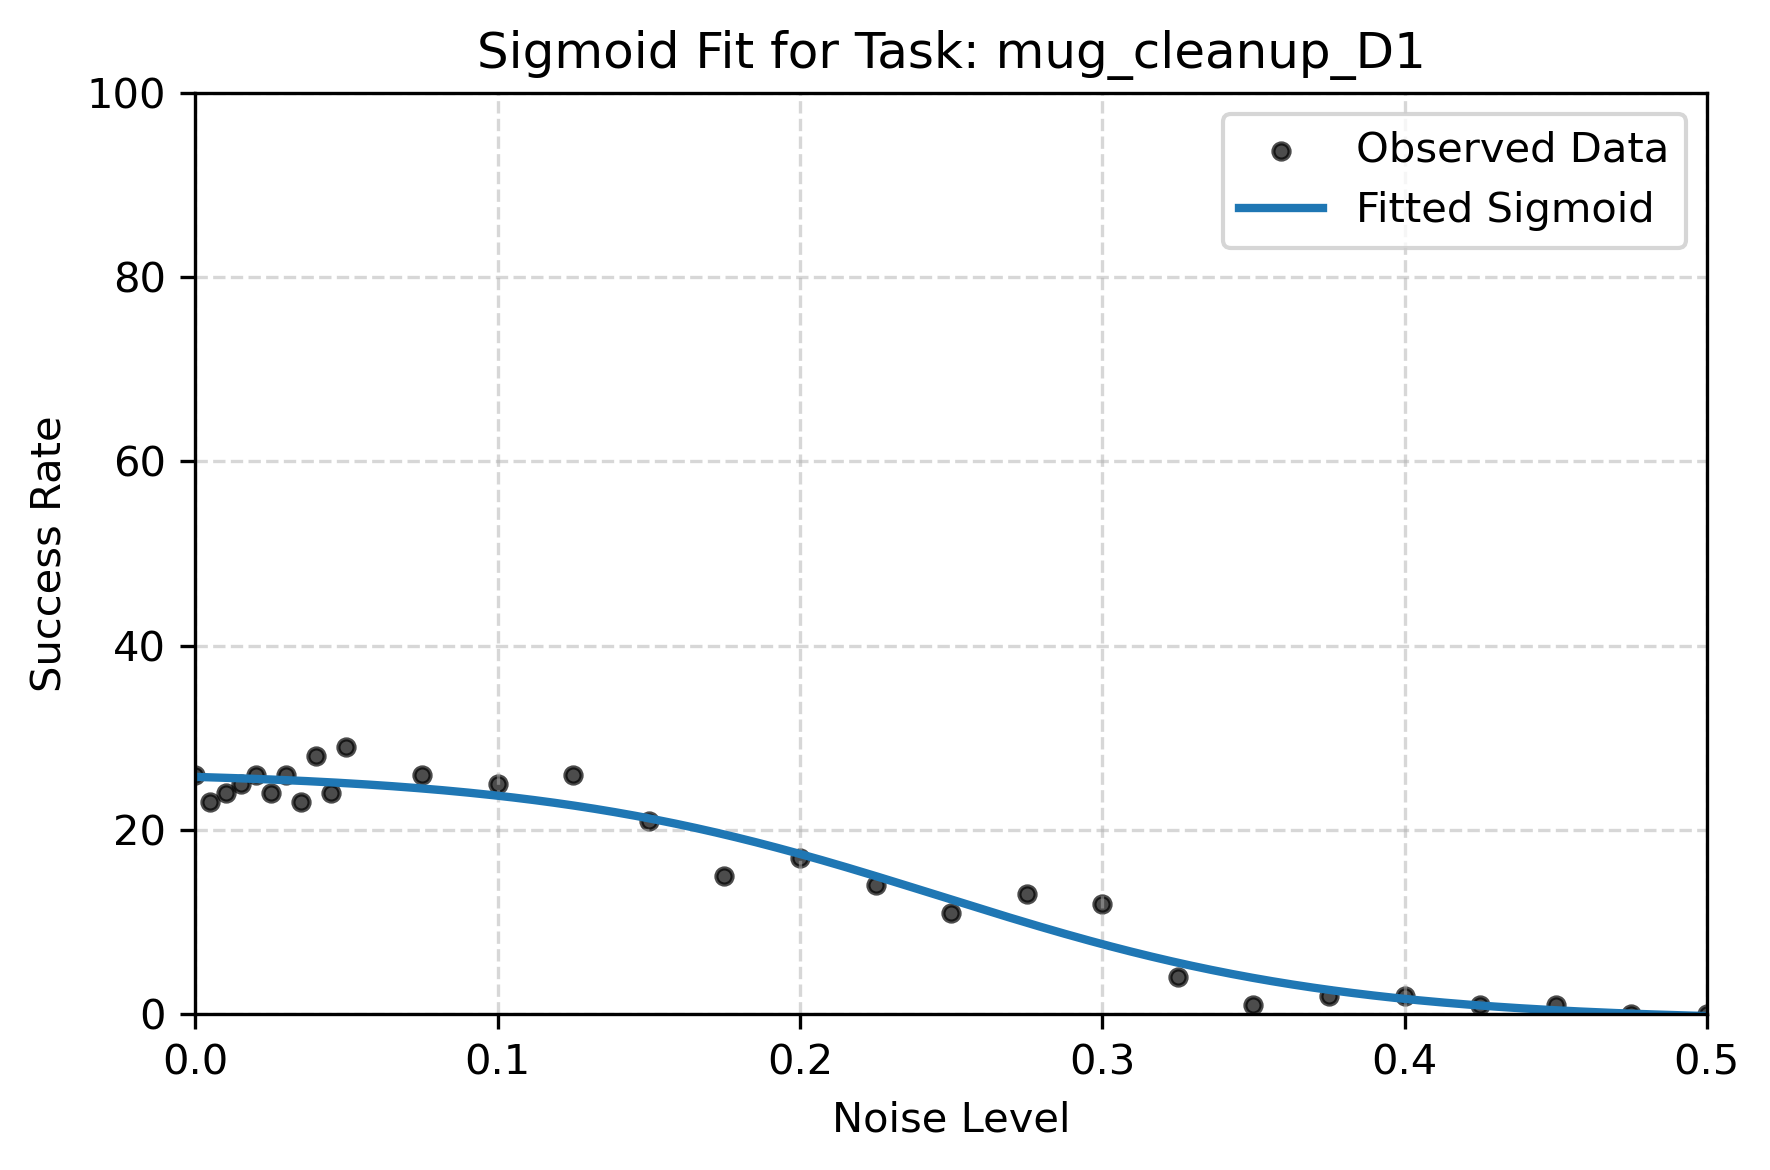

Parameters for task threading_D2: [-27.03680685   1.0097814   14.27804919  -1.81726634]
Performance with 0 noise: 23
SSE: 128.46806844411395


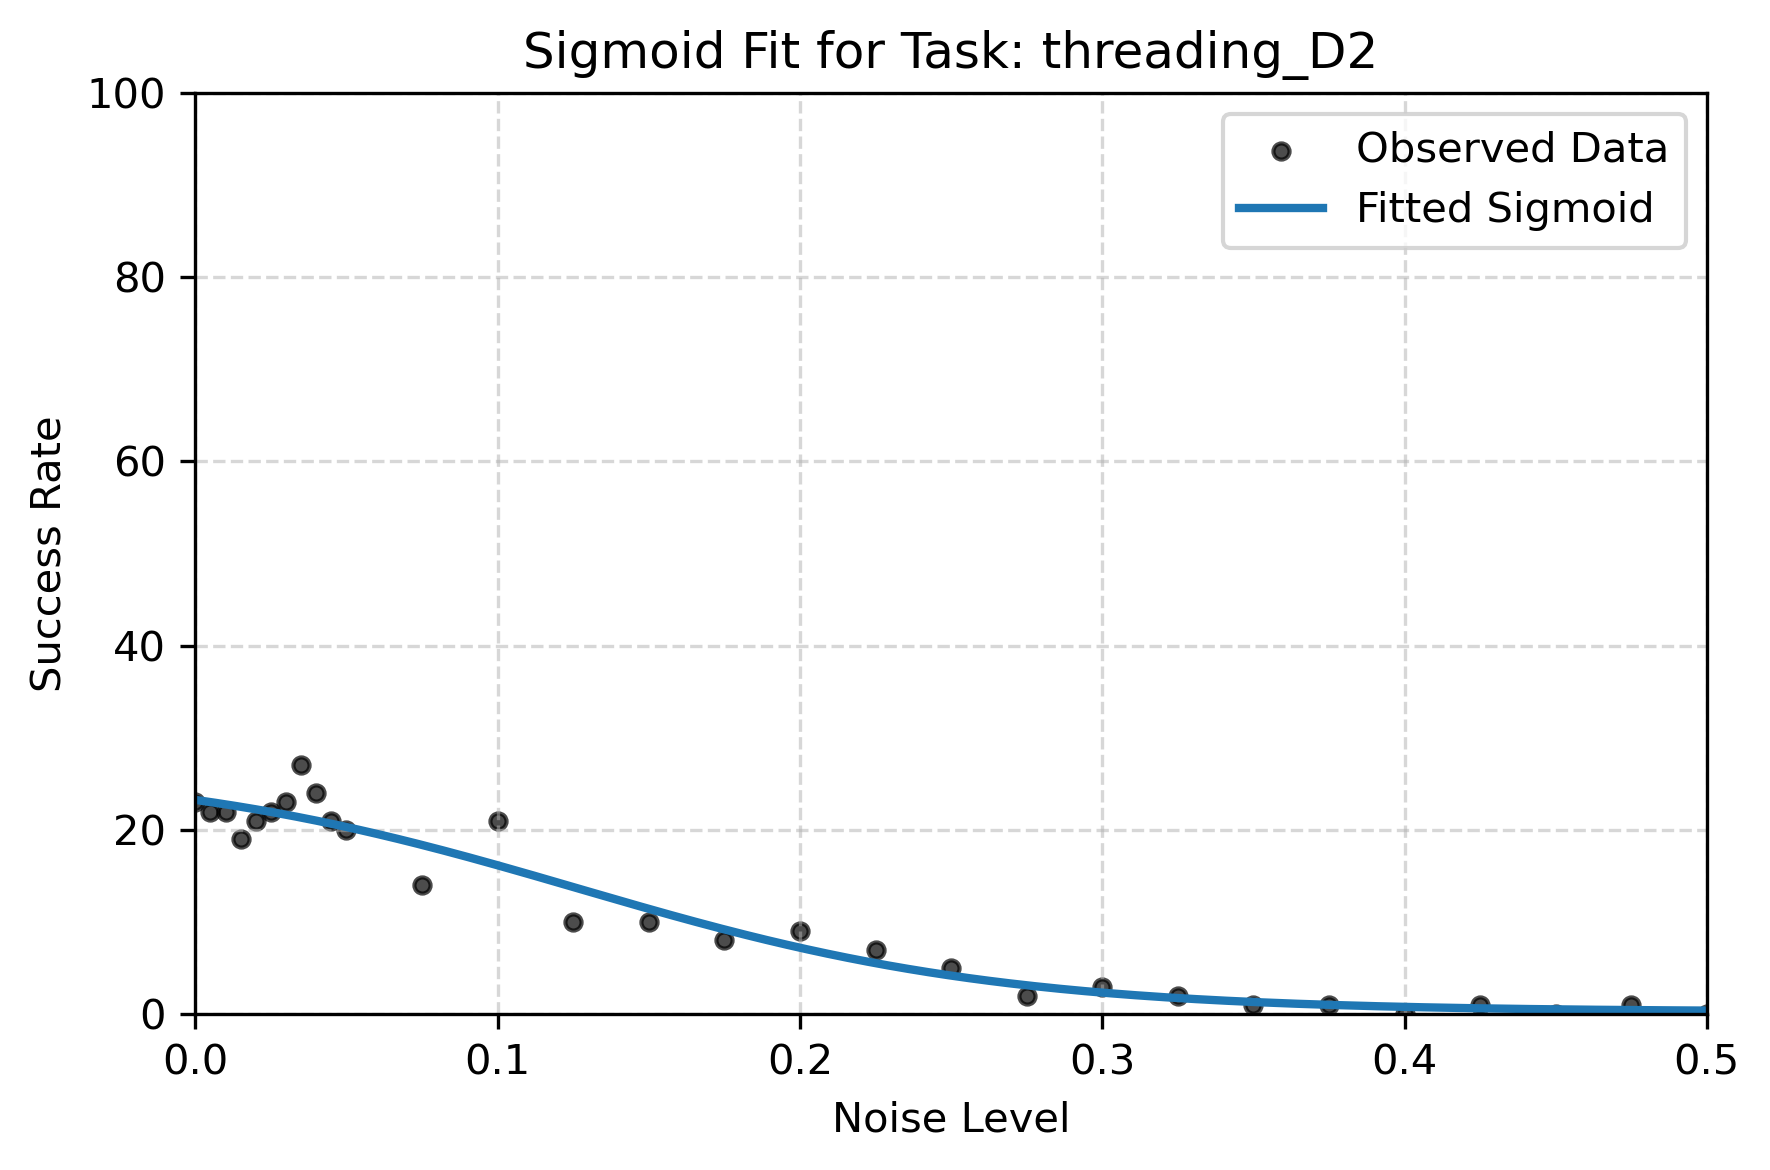

Parameters for task Cumulative_Data: [-54.06592499   1.0098287   16.35851451  -3.00944443]
Performance with 0 noise: 50.5
SSE: 48.07058531912567


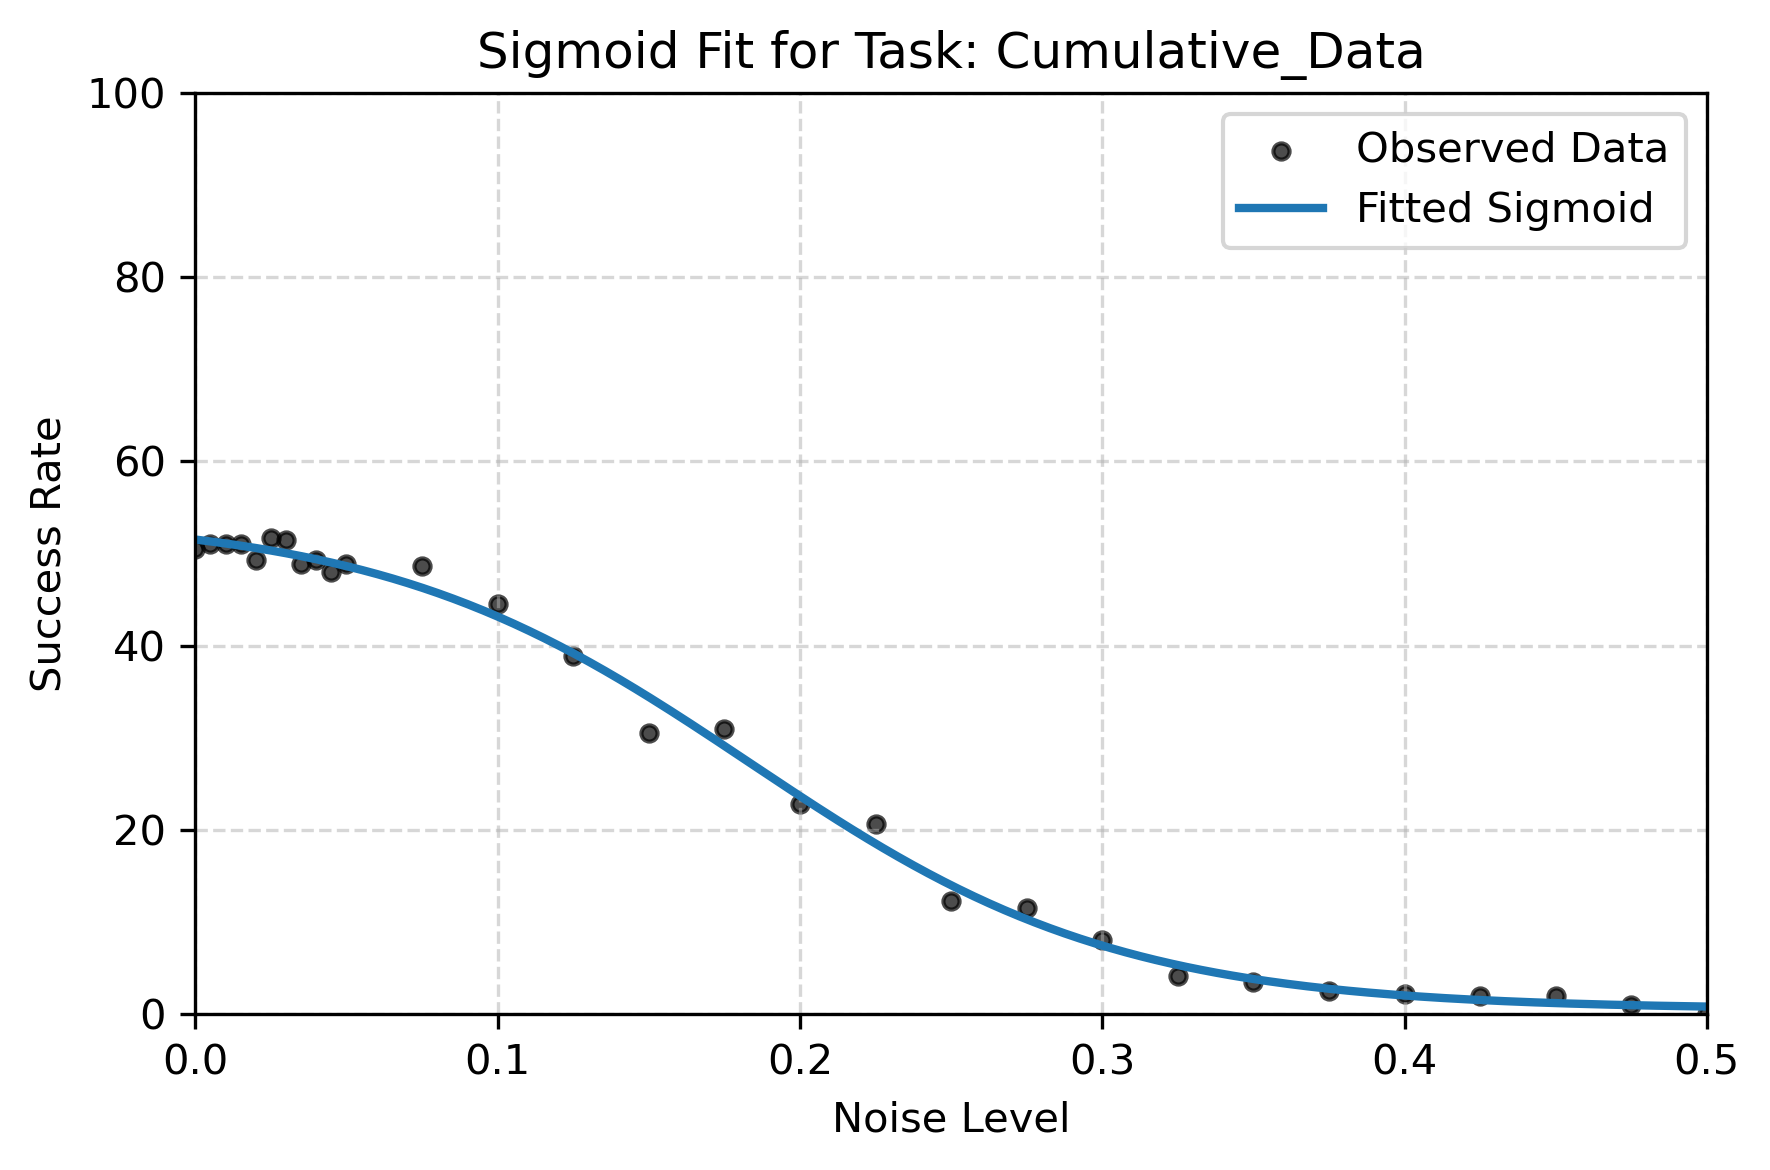

In [298]:
learned_parameters = []

# Loop through each task

for task in tasks:
    data_dir = os.path.expanduser("~/MimicGenProject/MimicGenProject/data")
    output_csv = os.path.join(data_dir, f"{task}.csv")
    data = pd.read_csv(output_csv)
    data = data[data["noise"] < 1.0]

    # Your data
    x_data = data["noise"].to_numpy()
    y_data = data["success_rate"].to_numpy() if task != "Cumulative_Data" else data["avg accuracy"].to_numpy()

    # Your sigmoid function
    def custom_sigmoid(x, A, B, C, D):
        return A * (1/(B + np.exp(-C * x - D)) - 1)

    # Fit the model
    params_opt, params_cov = curve_fit(custom_sigmoid, x_data, y_data, p0=initial_guess, bounds=param_bounds)
    
    if task != "Cumulative_Data":
        # Add params_opt copy but with f(0) added to the list
        learned_parameters.append([y_data[0], y_data[18], params_opt[1], params_opt[2], params_opt[3]])

    print(f"Parameters for task {task}: {str(params_opt)}")
    print(f"Performance with 0 noise: {y_data[0]}")
    SSE = np.sum((y_data - custom_sigmoid(x_data, *params_opt))**2)
    print(f"SSE: {SSE}")
    # Put the SSE in the summary_statistics DataFrame
    summary_statistics.loc[task, 'SSE1'] = SSE
    # Add RMSE and MAE to summary_statistics
    RMSE = np.sqrt(SSE / len(x_data))
    MAE = np.mean(np.abs(y_data - custom_sigmoid(x_data, *params_opt)))
    summary_statistics.loc[task, 'RMSE1'] = RMSE
    summary_statistics.loc[task, 'MAE1'] = MAE
    # Add R^2 to summary_statistics
    y_mean = np.mean(y_data)
    SS_total = np.sum((y_data - y_mean)**2)
    SS_residual = np.sum((y_data - custom_sigmoid(x_data, *params_opt))**2)
    R_squared = 1 - (SS_residual / SS_total)
    summary_statistics.loc[task, 'R_squared1'] = R_squared
    
    if MAKE_GRAPHS_A:
        # Plot
        plt.figure(figsize=(6, 4), dpi=300)
        plt.scatter(x_data, y_data, label='Observed Data', color='black', s=15, alpha=0.7)

        x_fit = np.linspace(min(x_data), max(x_data), 300)
        y_fit = custom_sigmoid(x_fit, *params_opt)
        plt.plot(x_fit, y_fit, label='Fitted Sigmoid', linewidth=2)

        # Labels and styling
        plt.title(f"Sigmoid Fit for Task: {task}", fontsize=12)
        plt.xlabel("Noise Level", fontsize=10)
        plt.ylabel("Success Rate", fontsize=10)
        plt.ylim(0,100)
        plt.xlim(0,.5)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()

        # Optional: save figure
        # fig_path = os.path.join(data_dir, f"{task}_fit.png")
        # plt.savefig(fig_path, dpi=300)
        if SAVE_FILE:
            plt.savefig(os.path.join(data_dir, f"charts/full_sigmoid/{task}_fit.png"), dpi=300)
        plt.show()

In [299]:
def fit_parameter_models(task_params):
    data = np.array(task_params)
    P_vals = data[:, 0]  # Assumed equal to A and D
    B_vals = data[:, 2]
    C_vals = data[:, 3]
    E_vals = data[:, 4]

    # Fit linear regressions: param = a*P + b

    def fit_linear(y):
        model = LinearRegression()
        model.fit(P_vals.reshape(-1, 1), y)
        return model.coef_[0], model.intercept_

    b1, b0 = fit_linear(B_vals)
    c1, c0 = fit_linear(C_vals)
    e1, e0 = fit_linear(E_vals)

    print(f"Fitted parameter models:")
    print(f"B(P) = {b0:.4f} + {b1:.4f} * P")
    print(f"C(P) = {c0:.4f} + {c1:.4f} * P")
    print(f"E(P) = {e0:.4f} + {e1:.4f} * P")

    # Return a predictive sigmoid function
    def predicted_sigmoid(x, P):
        A = -P
        B = b0 + b1 * P
        C = c0 + c1 * P
        E = e0 + e1 * P
        return chosen_function(x,A,B,C,E,P)

    return predicted_sigmoid

In [300]:
def fit_parameter_models_2D(task_params):
    data = np.array(task_params)
    P_vals = data[:, 0]  # Assumed equal to A and D
    Q_vals = data[:, 1]
    B_vals = data[:, 2]
    C_vals = data[:, 3]
    E_vals = data[:, 4]

    X = np.column_stack((P_vals,Q_vals))

    # Fit linear regressions: param = a*P + b
    def fit_linear(y):
        model = LinearRegression()
        model.fit(X, y)
        return model.intercept_, model.coef_

    b0, b_coeffs = fit_linear(B_vals)
    c0, c_coeffs = fit_linear(C_vals)
    e0, e_coeffs = fit_linear(E_vals)

    b1,b2 = b_coeffs
    c1,c2 = c_coeffs
    e1,e2 = e_coeffs

    print(f"Fitted parameter models:")
    print(f"B(P, Q) = {b0:.4f} + {b1:.4f} * P + {b2:.4f} * Q")
    print(f"C(P, Q) = {c0:.4f} + {c1:.4f} * P + {c2:.4f} * Q")
    print(f"E(P, Q) = {e0:.4f} + {e1:.4f} * P + {e2:.4f} * Q")

    # Return a predictive sigmoid function
    def predicted_sigmoid(x, P, Q):
        A = -P
        B = b0 + b1 * P + b2 * Q
        C = c0 + c1 * P + c2 * Q
        E = e0 + e1 * P + e2 * Q
        return A / (B + np.exp(-C * x - E)) + A + 2*P

    return predicted_sigmoid

In [301]:
print(learned_parameters)

[[42, 25, 0.9742106754562609, 11.322164087488755, -2.710648769408732], [53, 8, 1.0033282369944372, 20.305021942473623, -3.629921834122213], [23, 4, 1.0255699849642825, 19.295835900861253, -3.436615906499969], [52, 10, 0.9953389729634623, 16.509247912282977, -3.339166152996724], [65, 6, 0.9935908330576871, 20.02083816642047, -3.133112044913083], [68, 21, 1.0401791966472451, 18.98068839758799, -3.5771252817783274], [93, 80, 1.2372782955391972, 16.52325601925555, -5.777088811671111], [43, 18, 0.9923703553267238, 18.38165618153863, -4.401792198685566], [39, 2, 1.007341291479437, 29.74014514172704, -3.976857951913116], [40, 1, 0.9915481274954793, 25.034288283866204, -3.215505969530374], [26, 11, 0.9712410438298607, 15.086485200690598, -3.689190102695618], [23, 5, 1.009781402435063, 14.278049192154505, -1.8172663424500246]]


In [302]:
# sigmoid_fn = fit_parameter_models(learned_parameters)

# # Plot for a given P
# x = np.linspace(0, 0.5, 200)
# P = 45.0
# y = sigmoid_fn(x, P)

# # plt.plot(x, y, label=f"P = {P}")
# # plt.xlabel("Noise")
# # plt.ylabel("Predicted Accuracy")
# # plt.legend()
# # plt.grid(True)
# # plt.show()

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 414.98889521540366


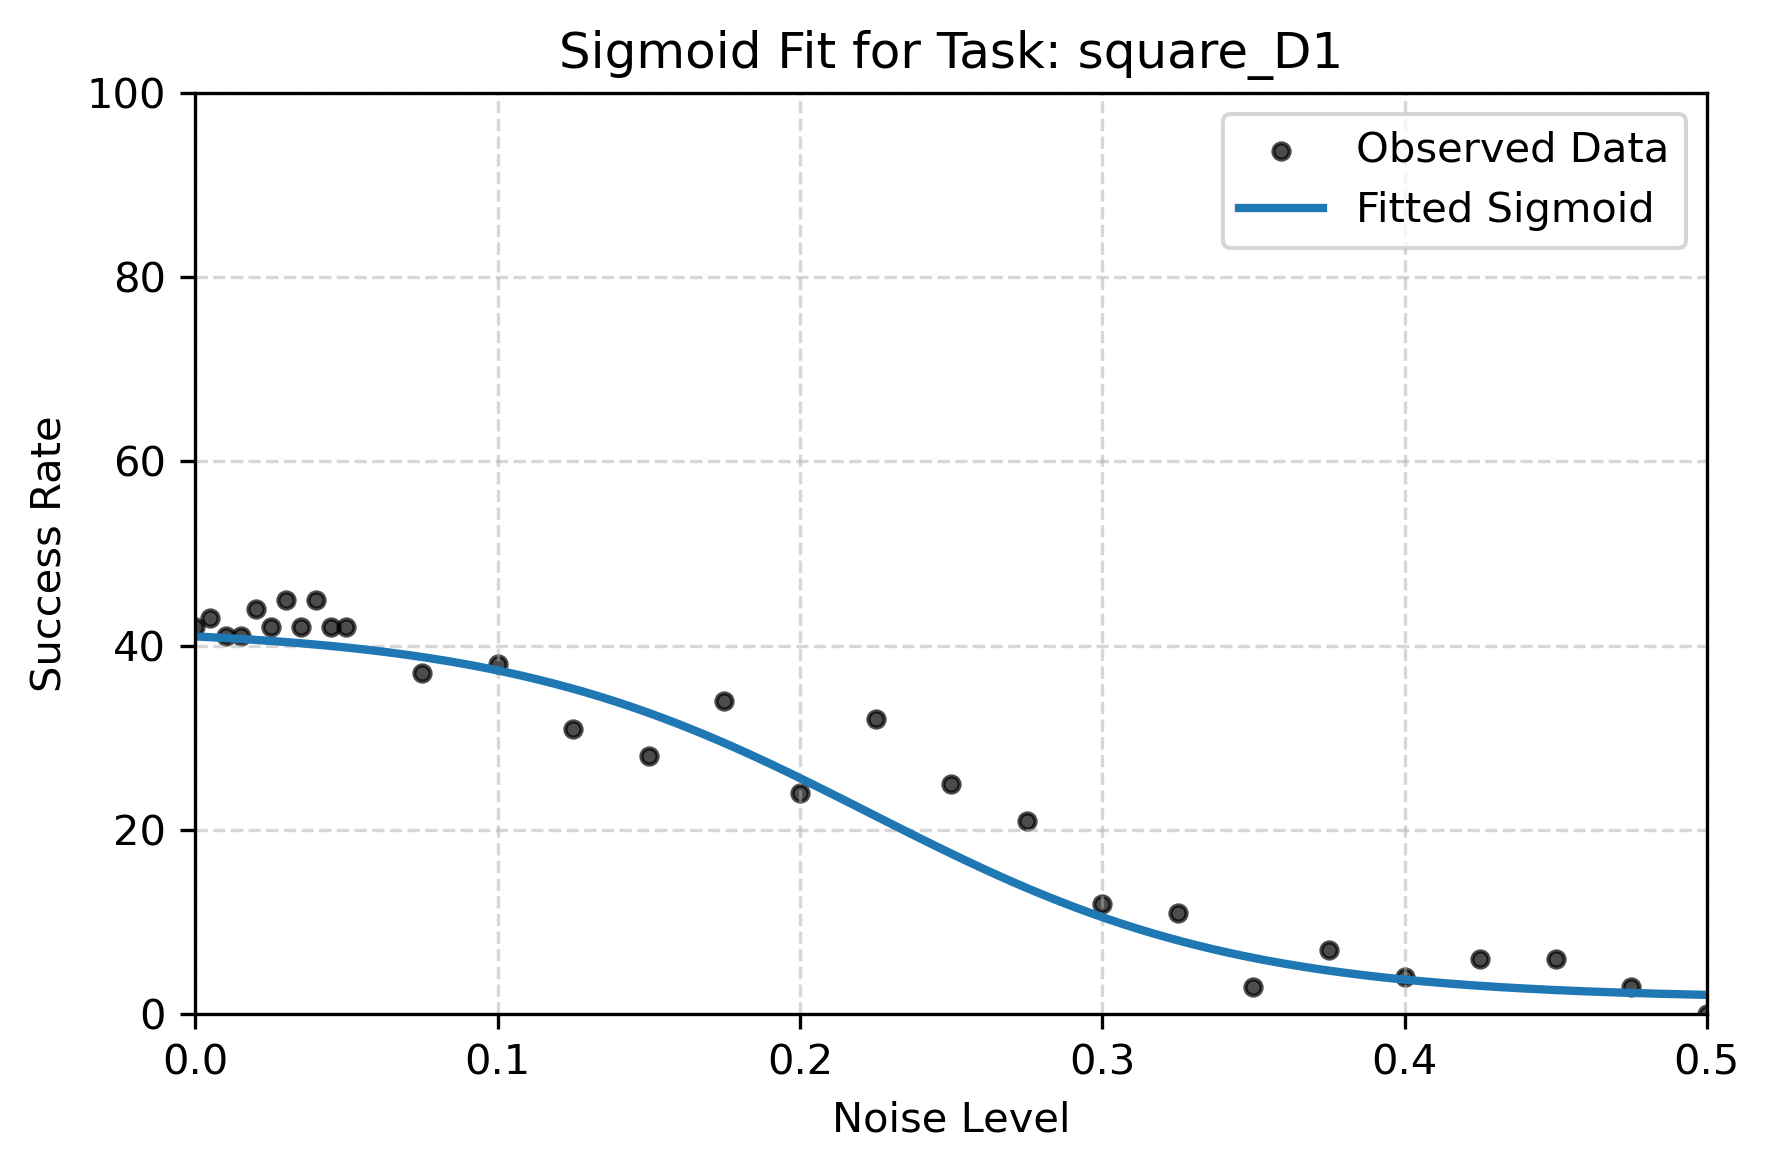

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 477.459187560282


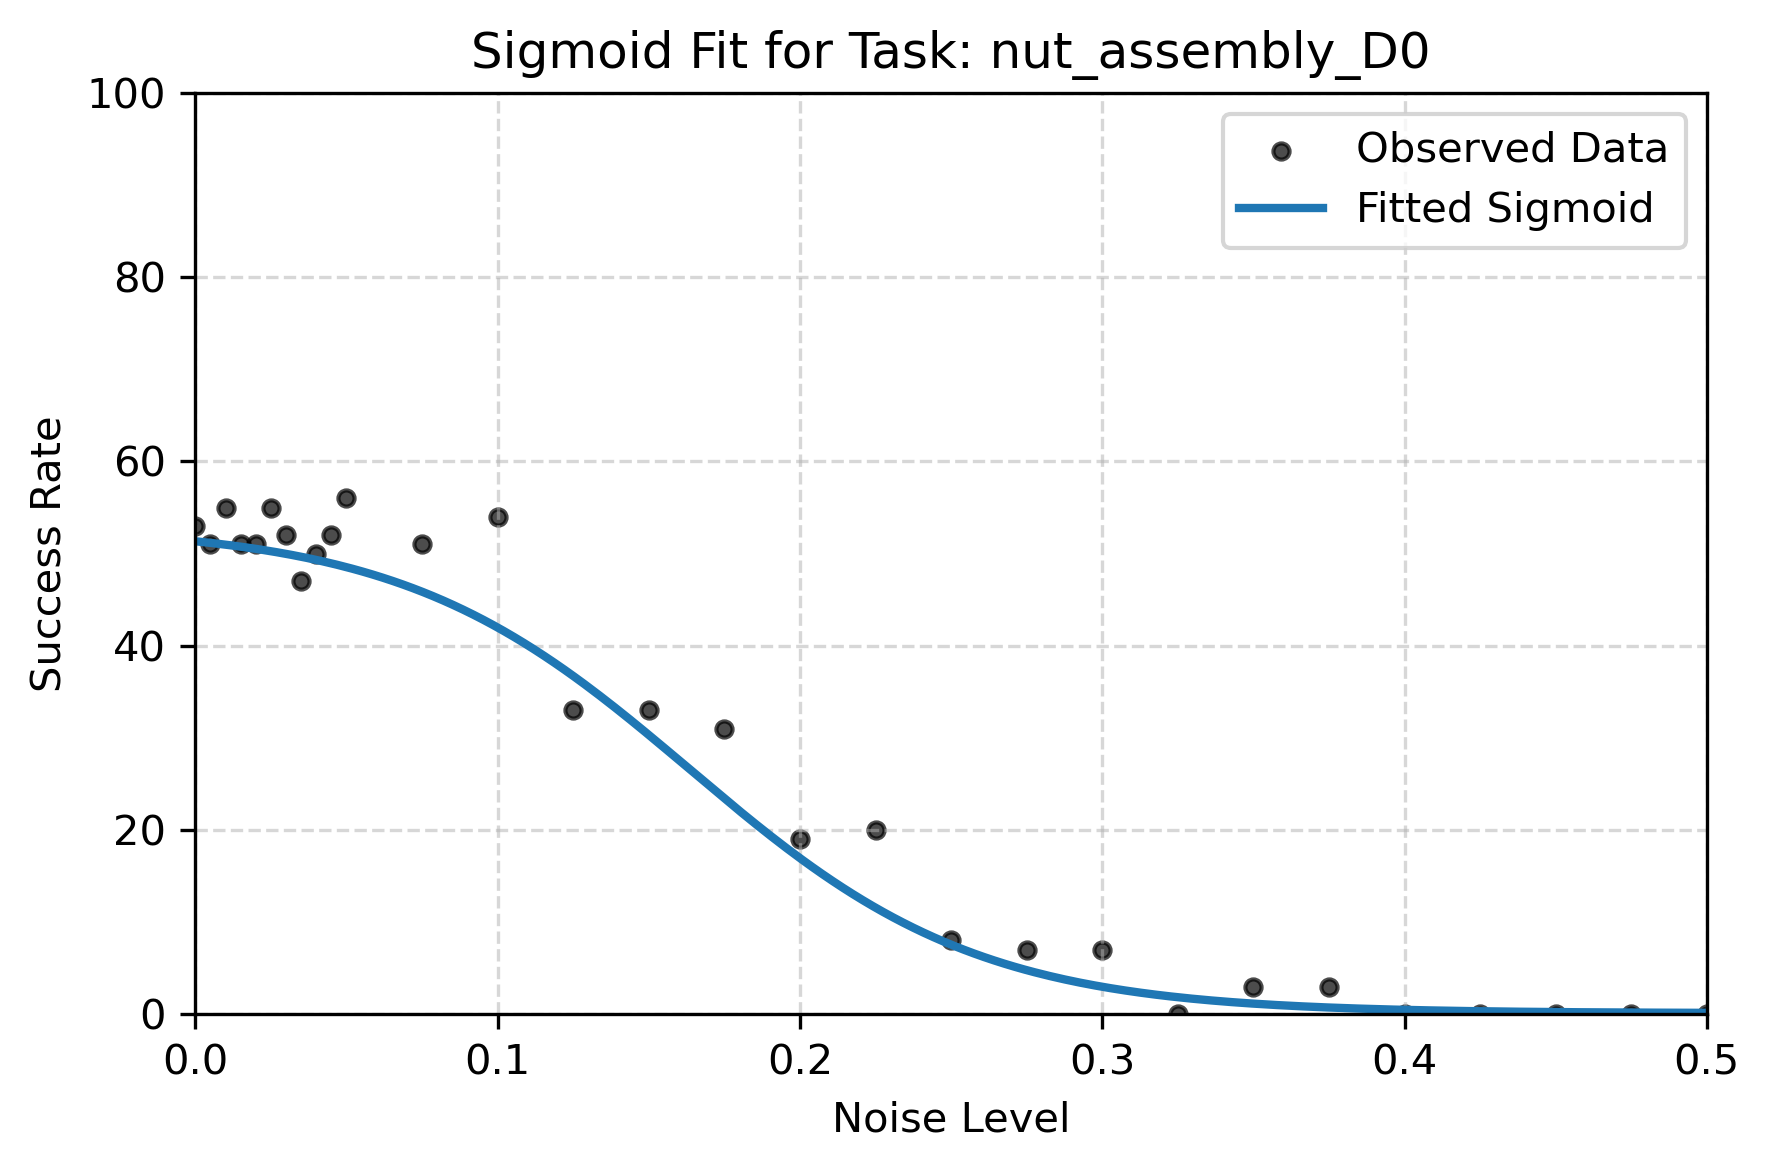

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 369.07591346097007


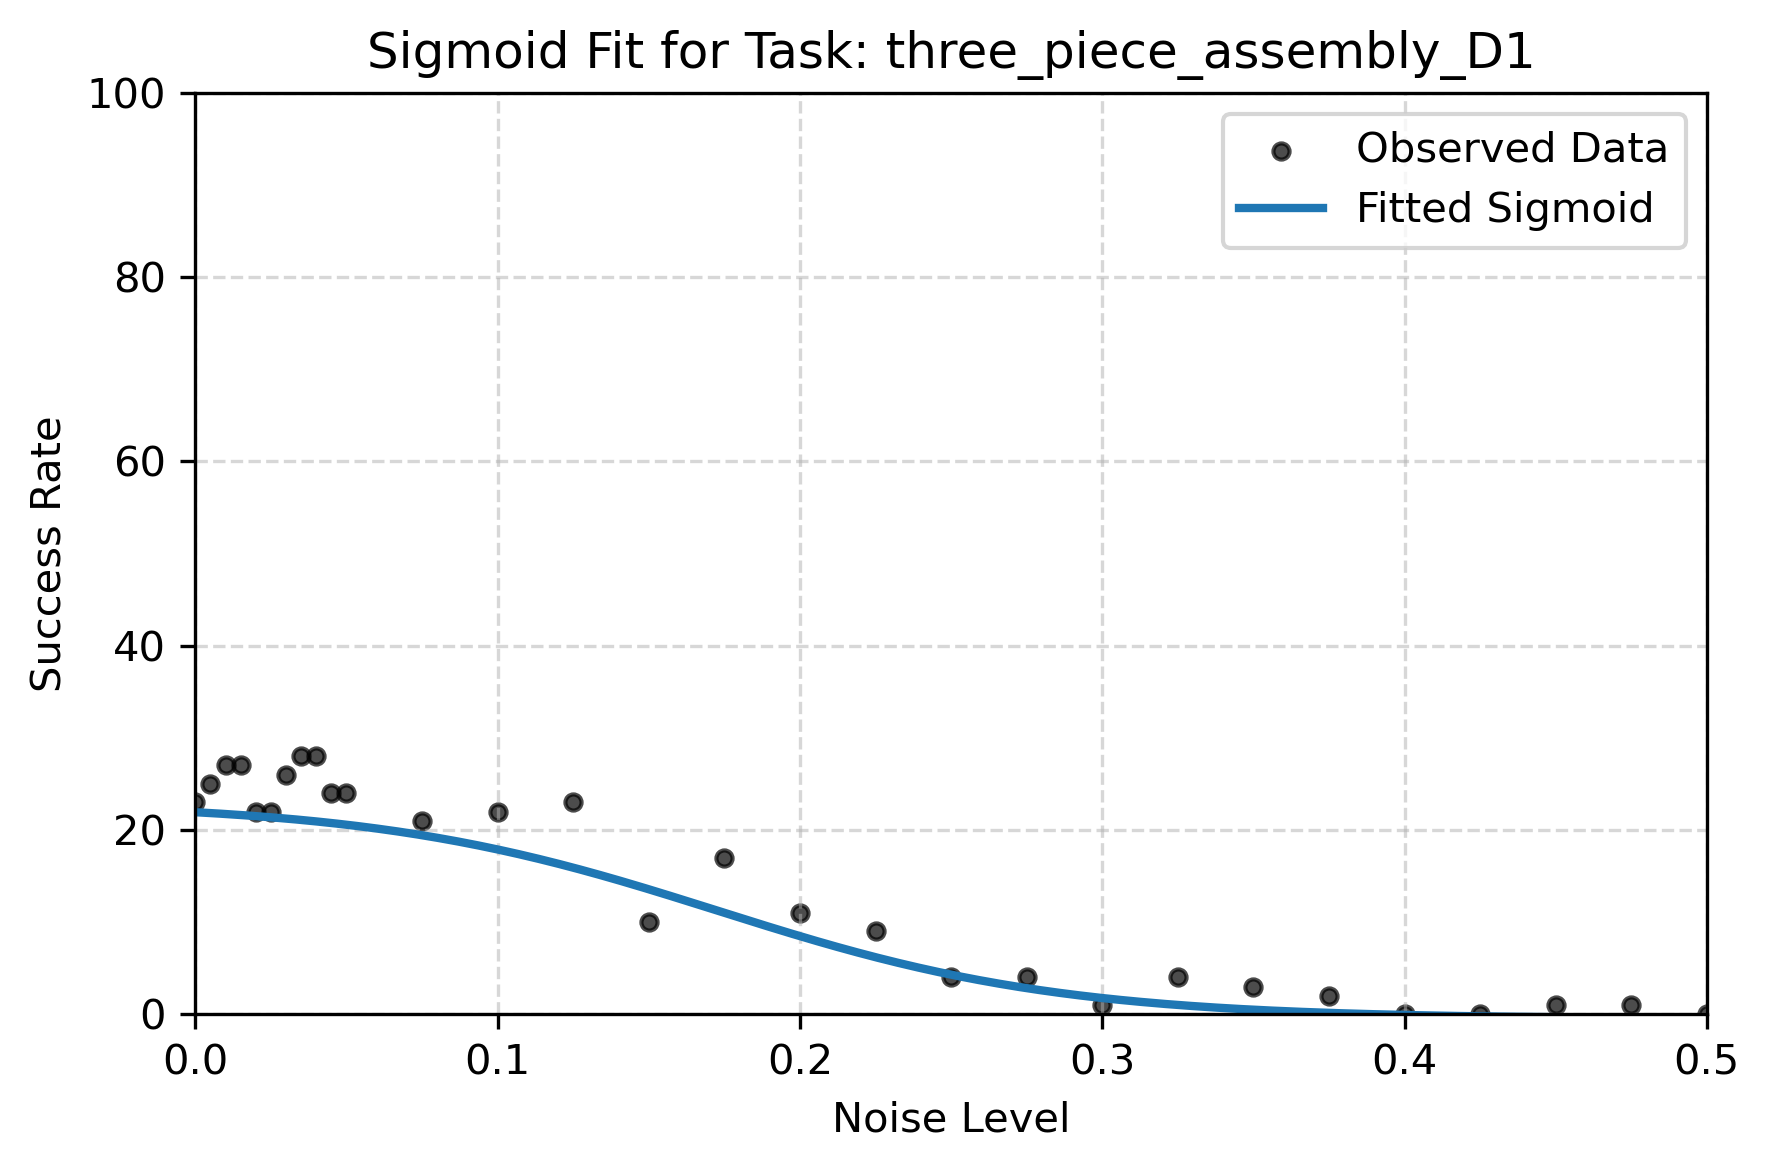

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 809.7497290298244


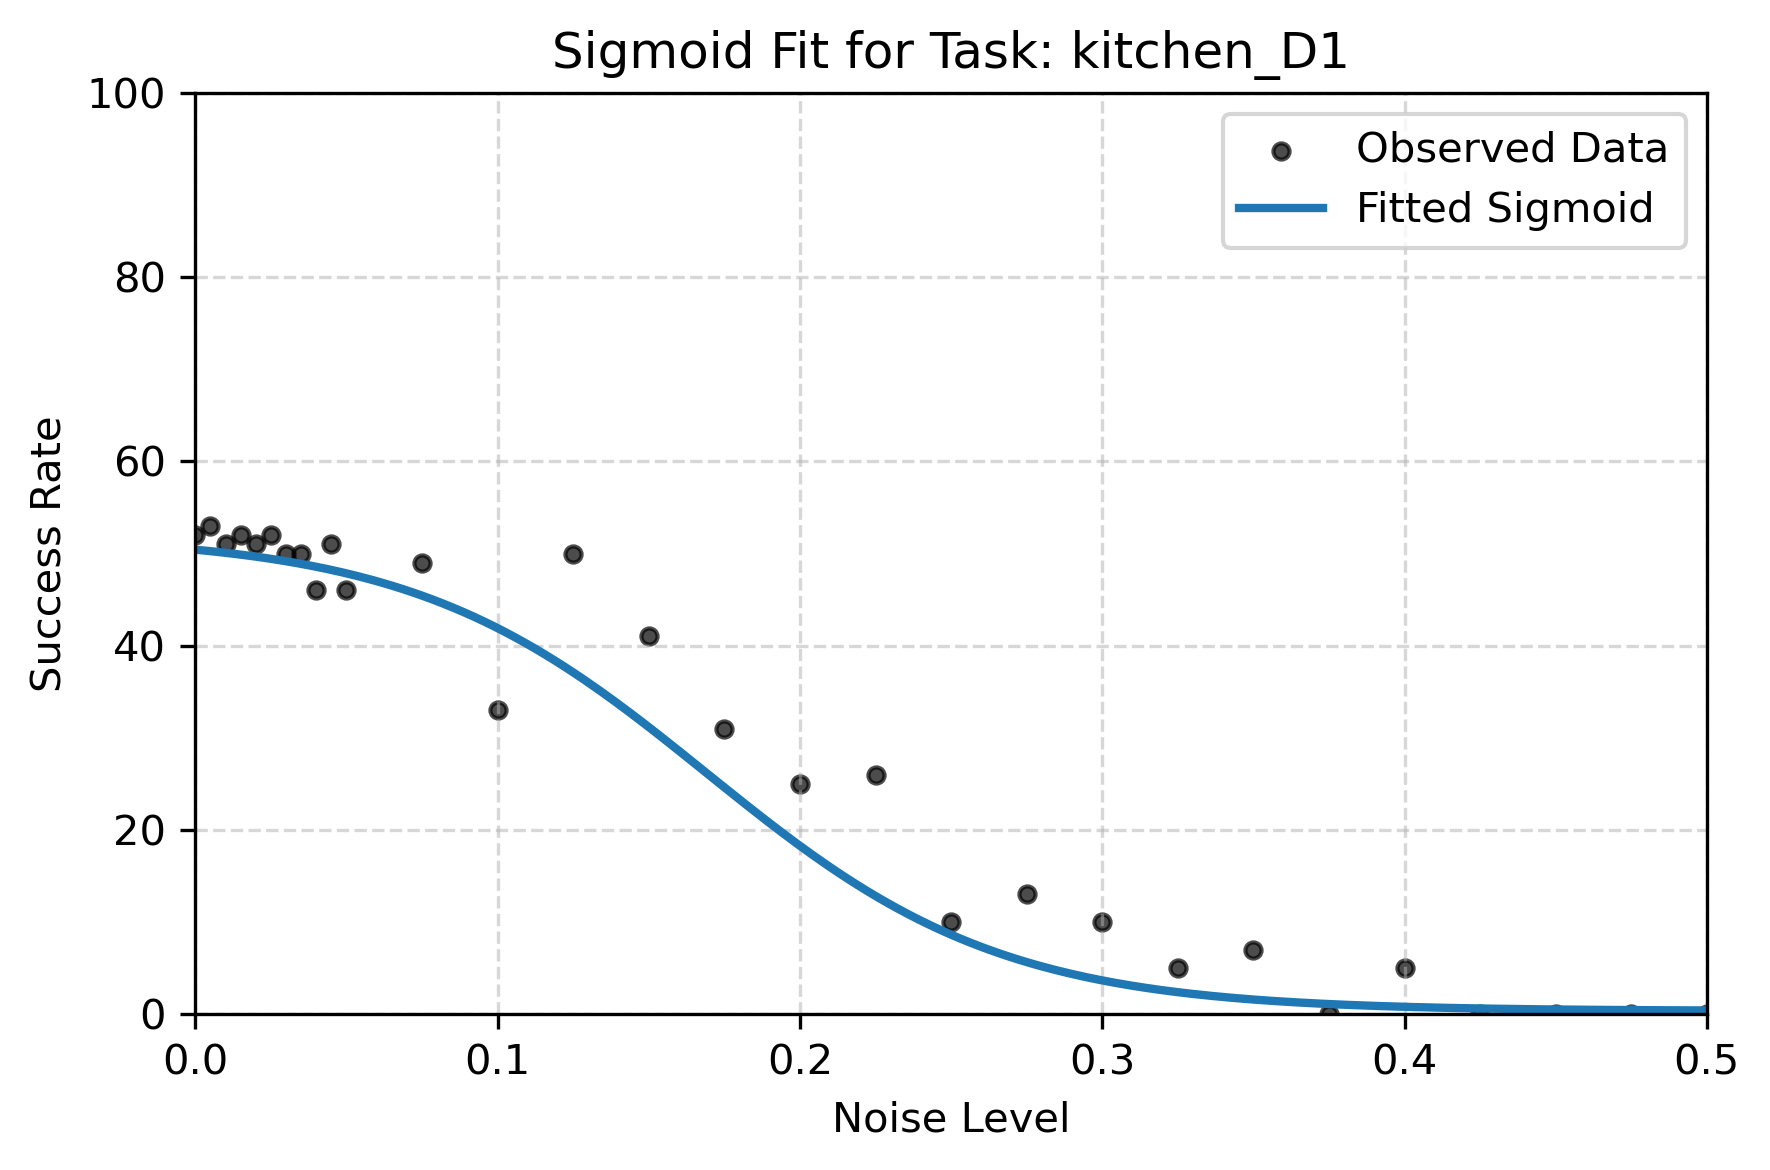

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 402.17635371395727


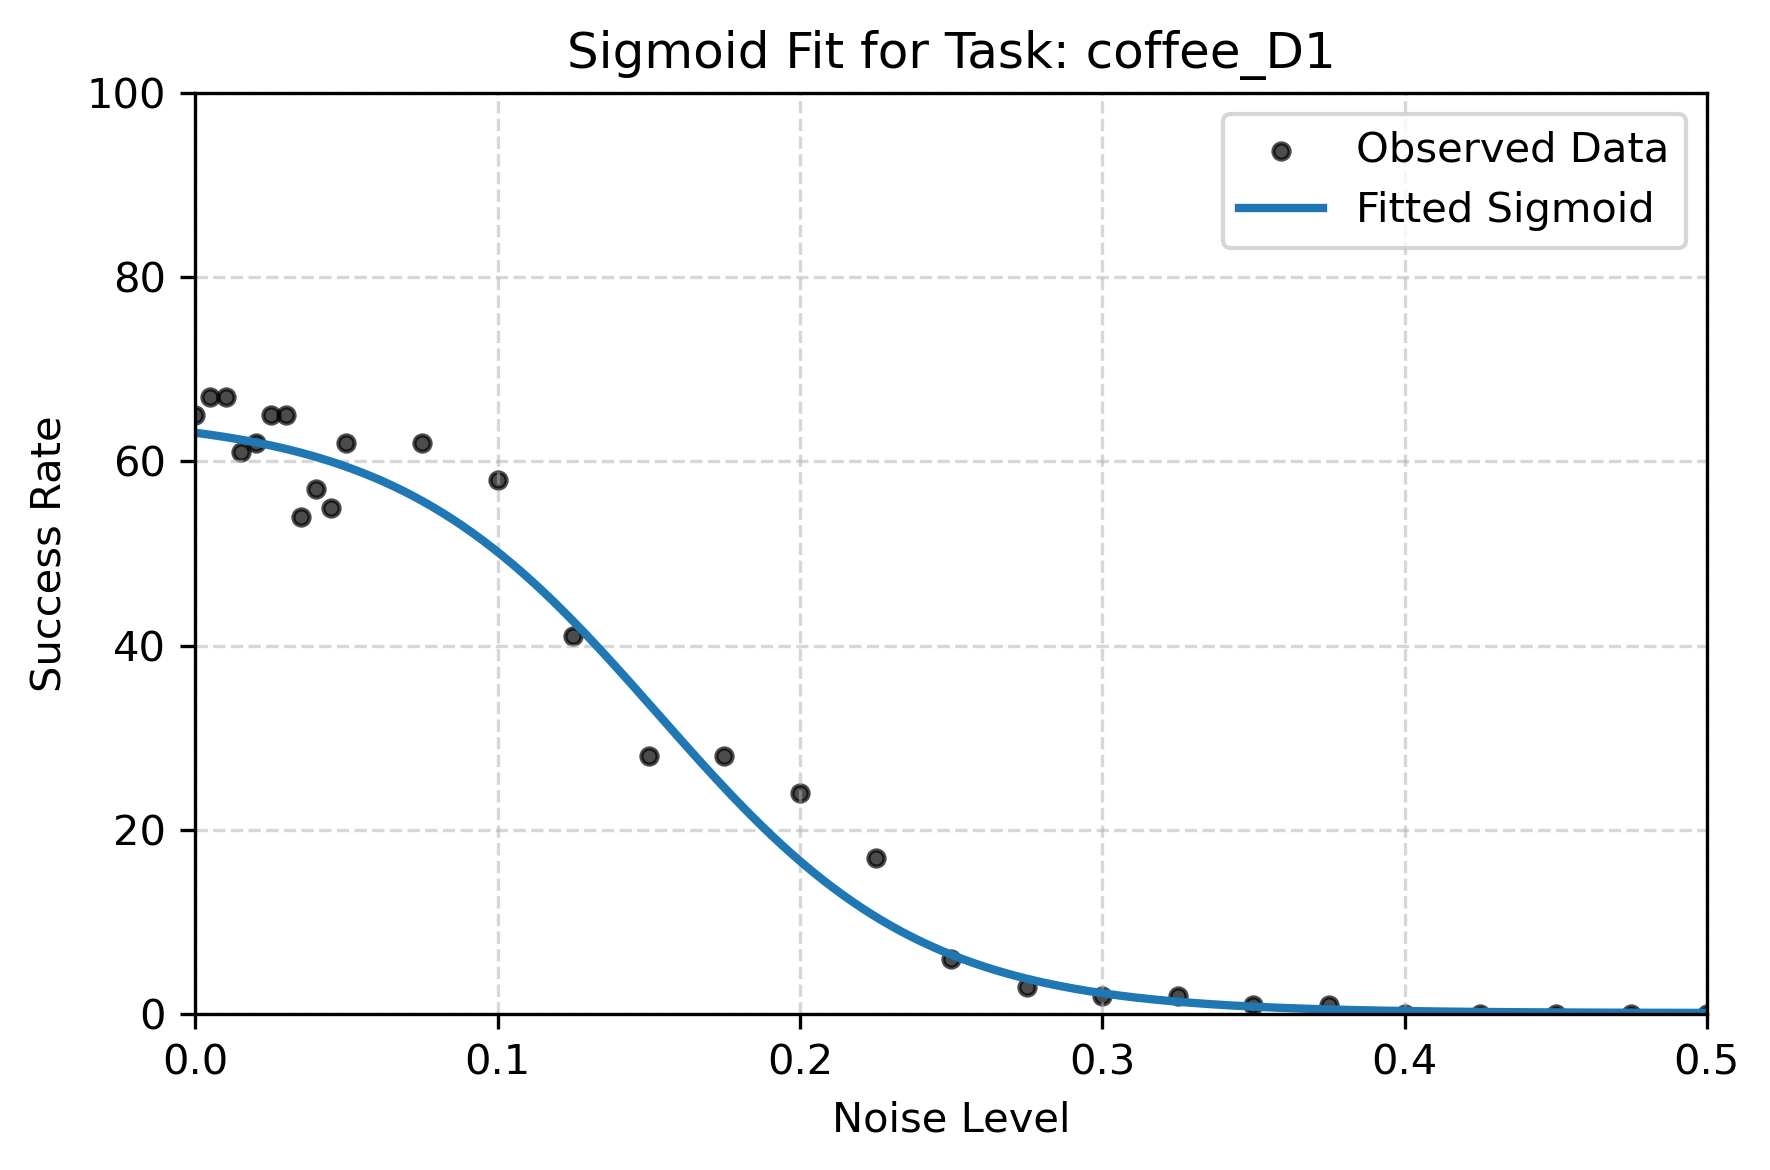

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 507.36537697744984


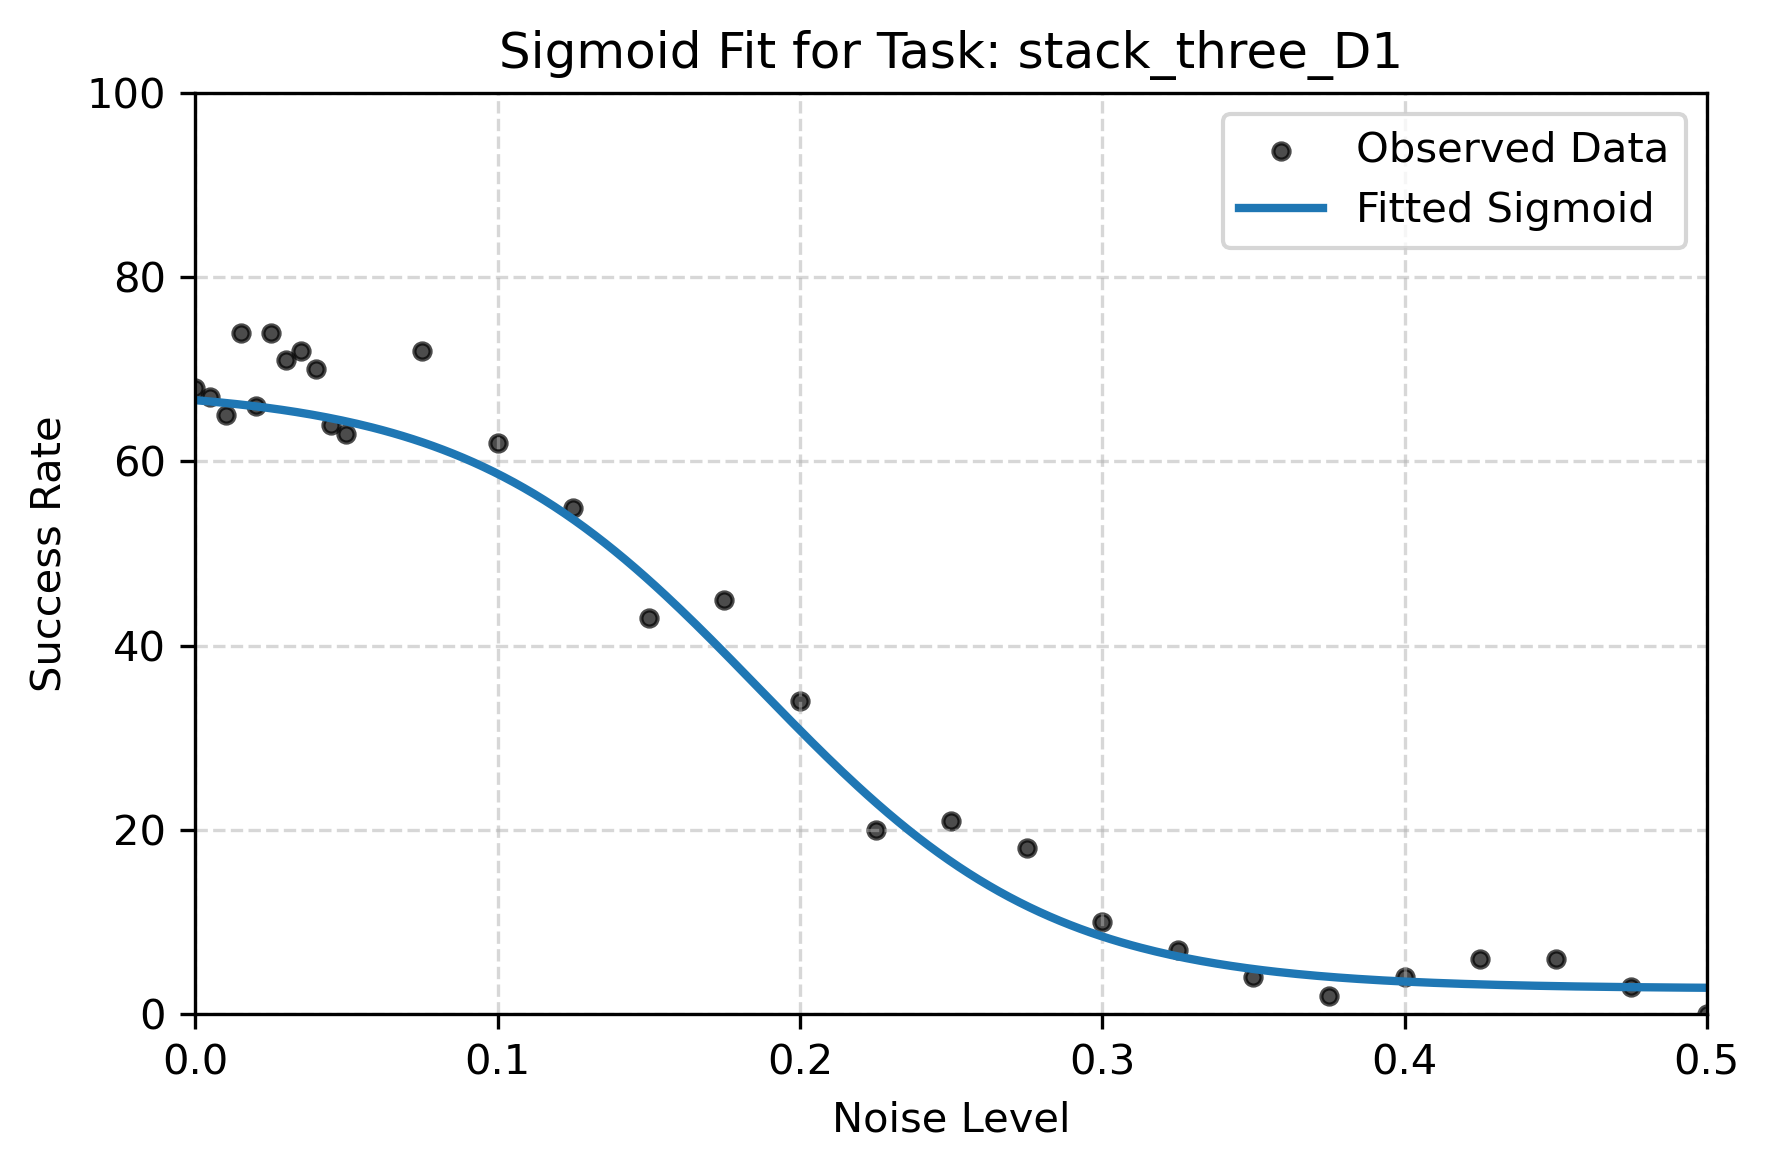

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 1427.502584023993


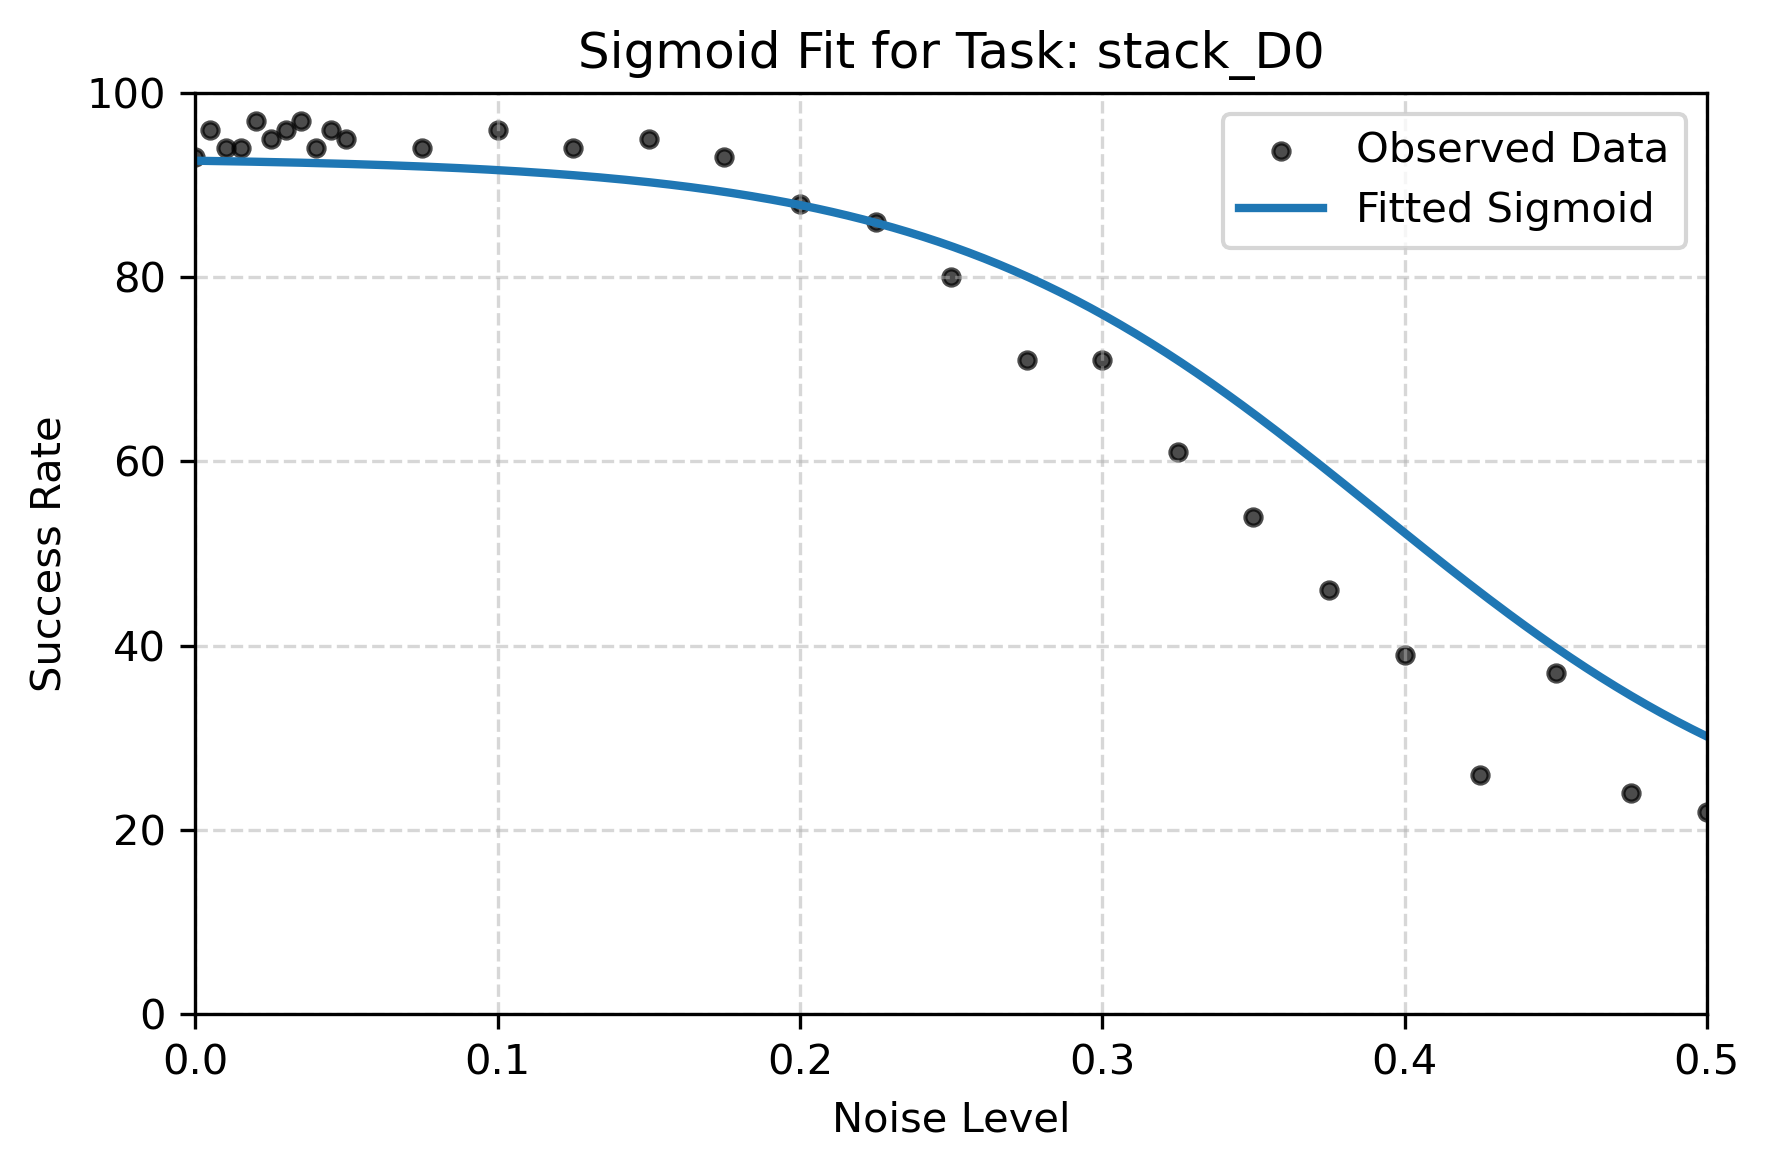

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 483.7082256125657


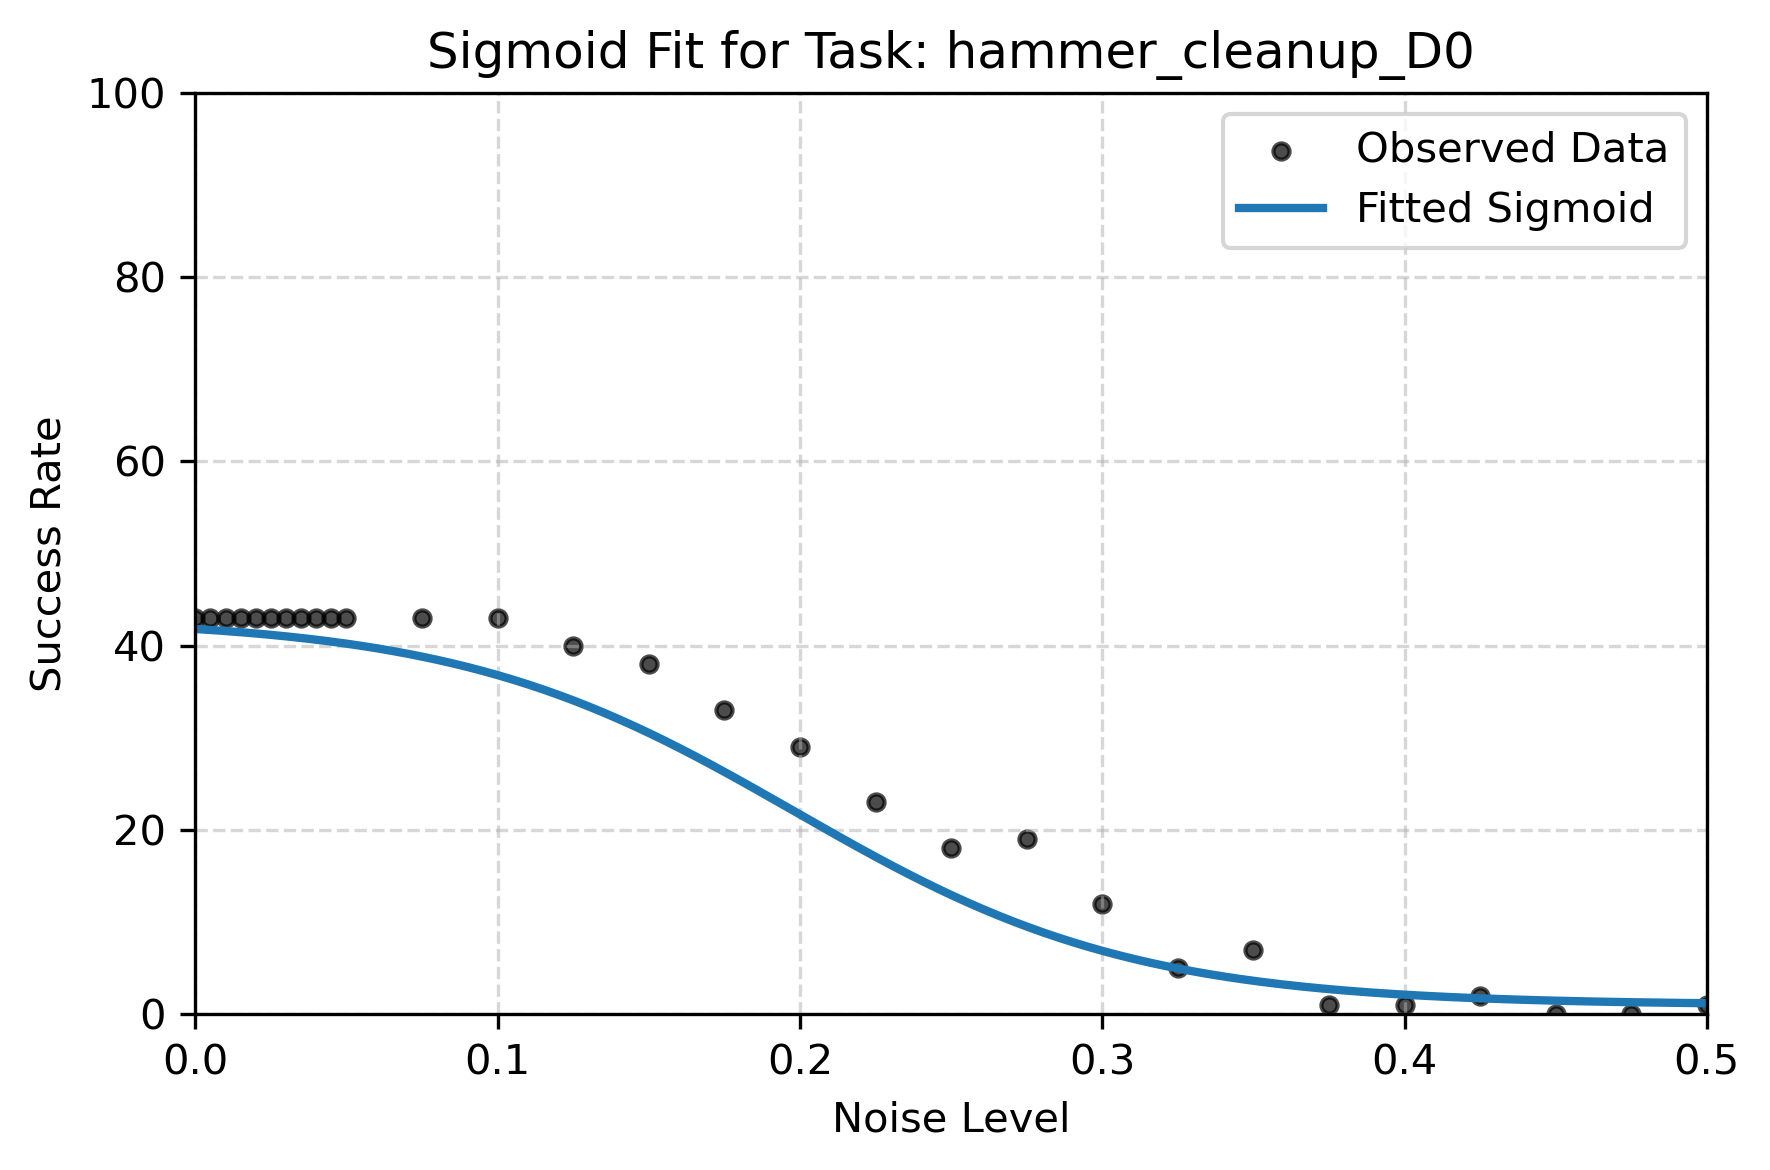

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 559.9937042113199


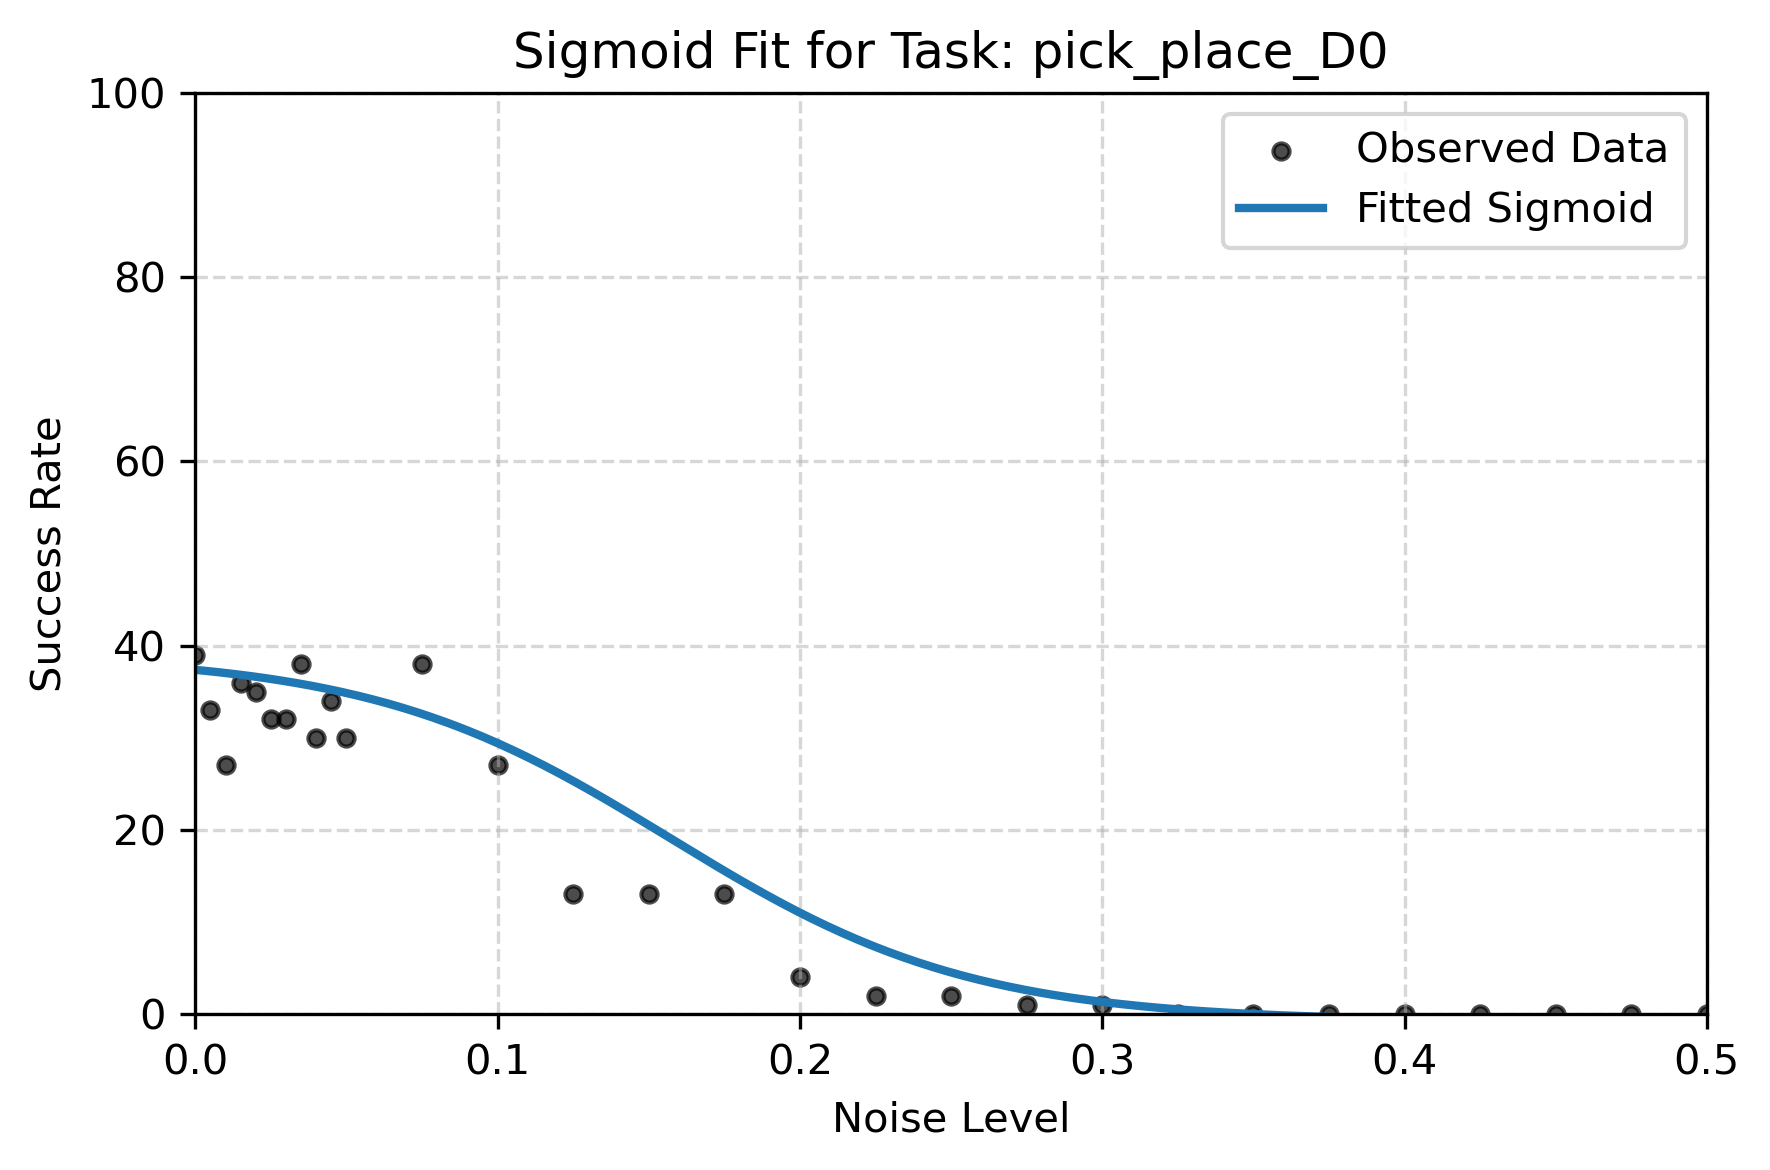

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 275.36180464598


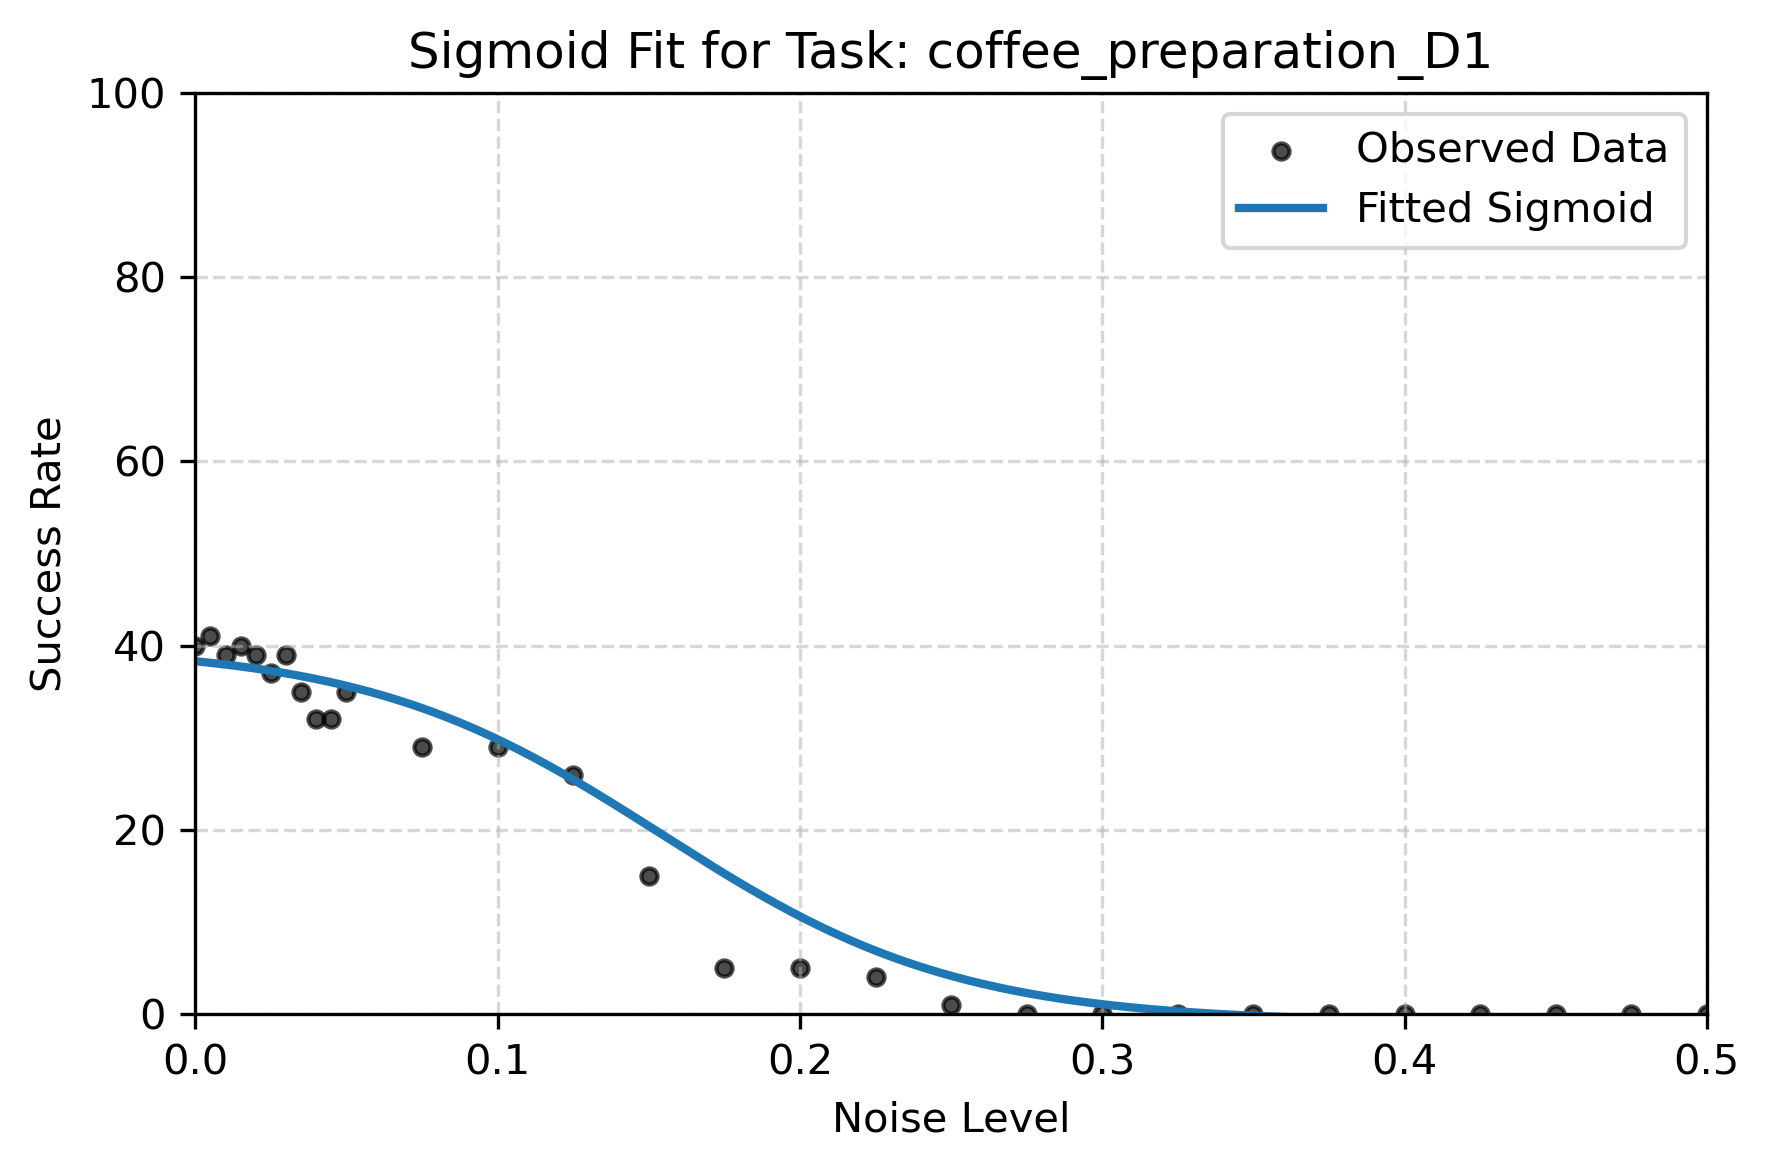

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 331.28692645208974


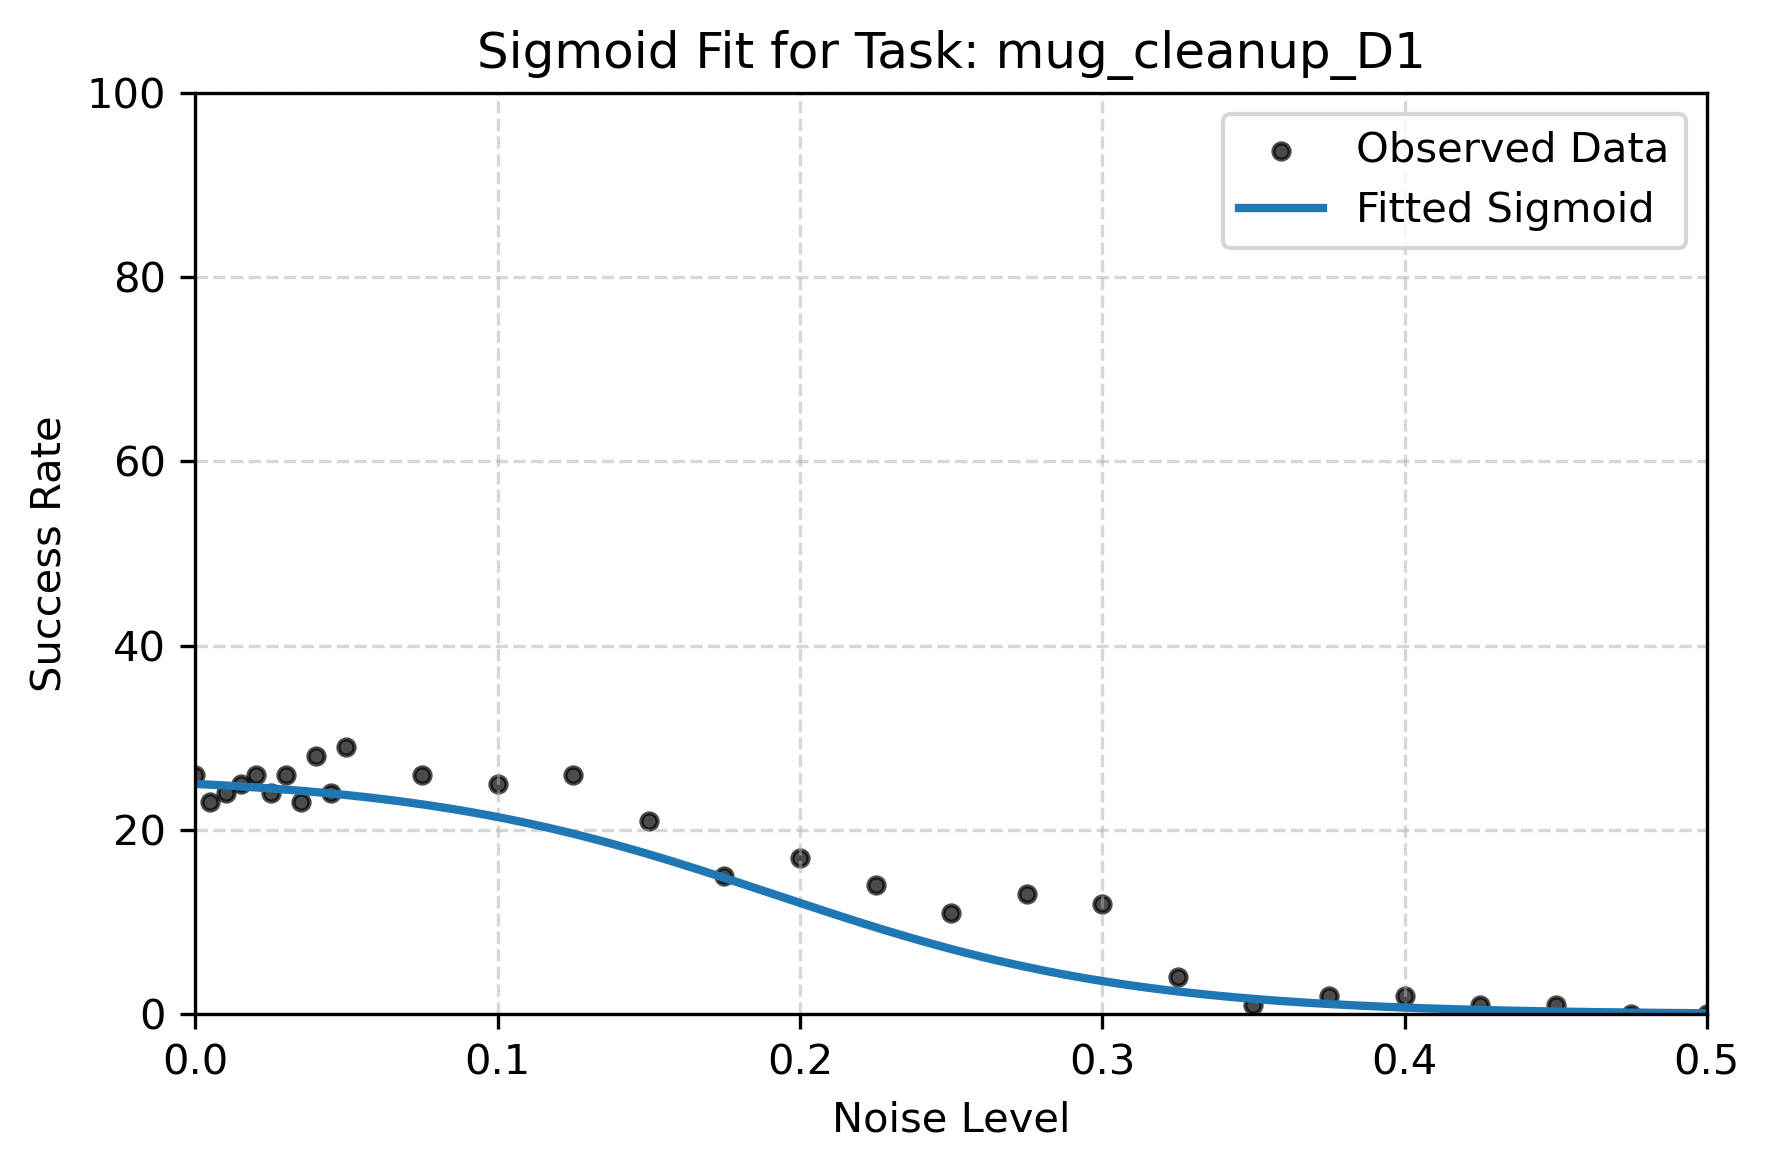

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 165.96835111129346


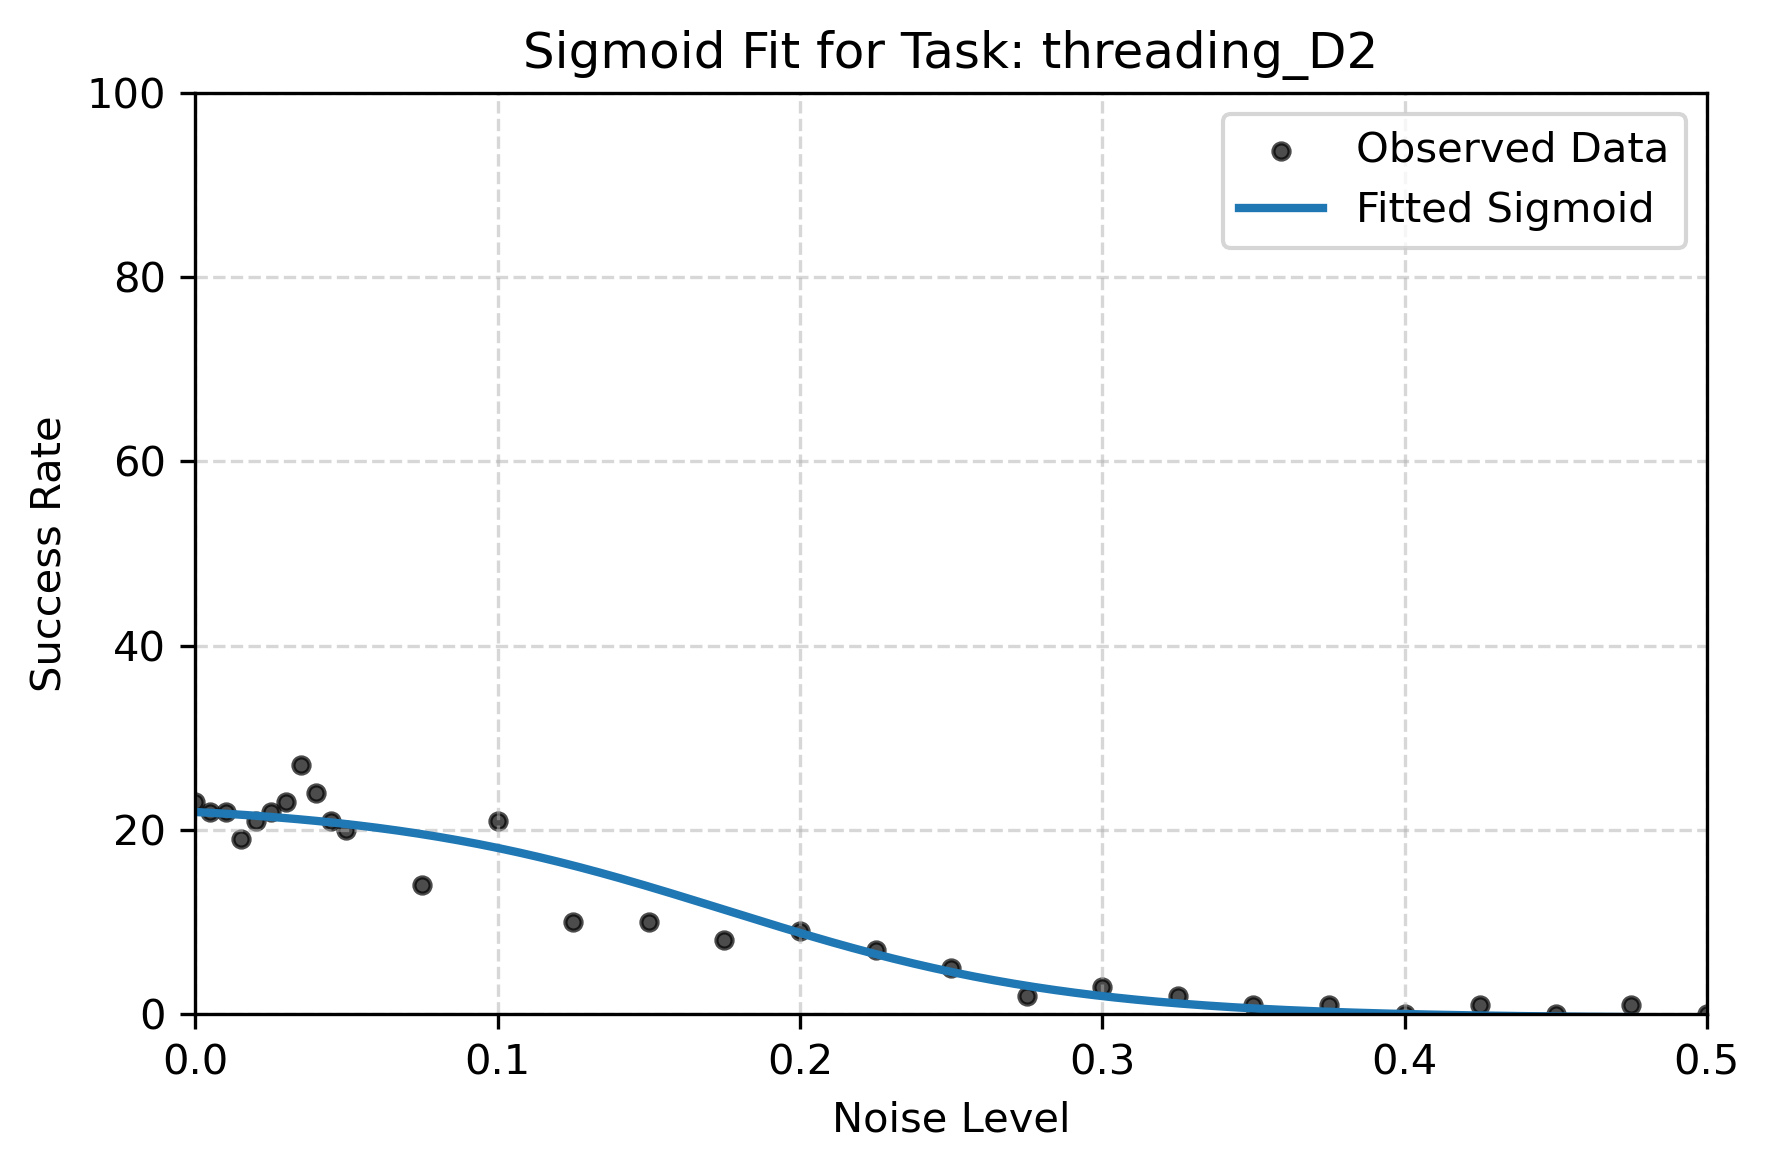

Fitted parameter models:
B(P, Q) = 0.9580 + 0.0004 * P + 0.0026 * Q
C(P, Q) = 15.1902 + 0.1352 * P + -0.1751 * Q
E(P, Q) = -2.6760 + -0.0107 * P + -0.0238 * Q
SSE: 210.71161113091753


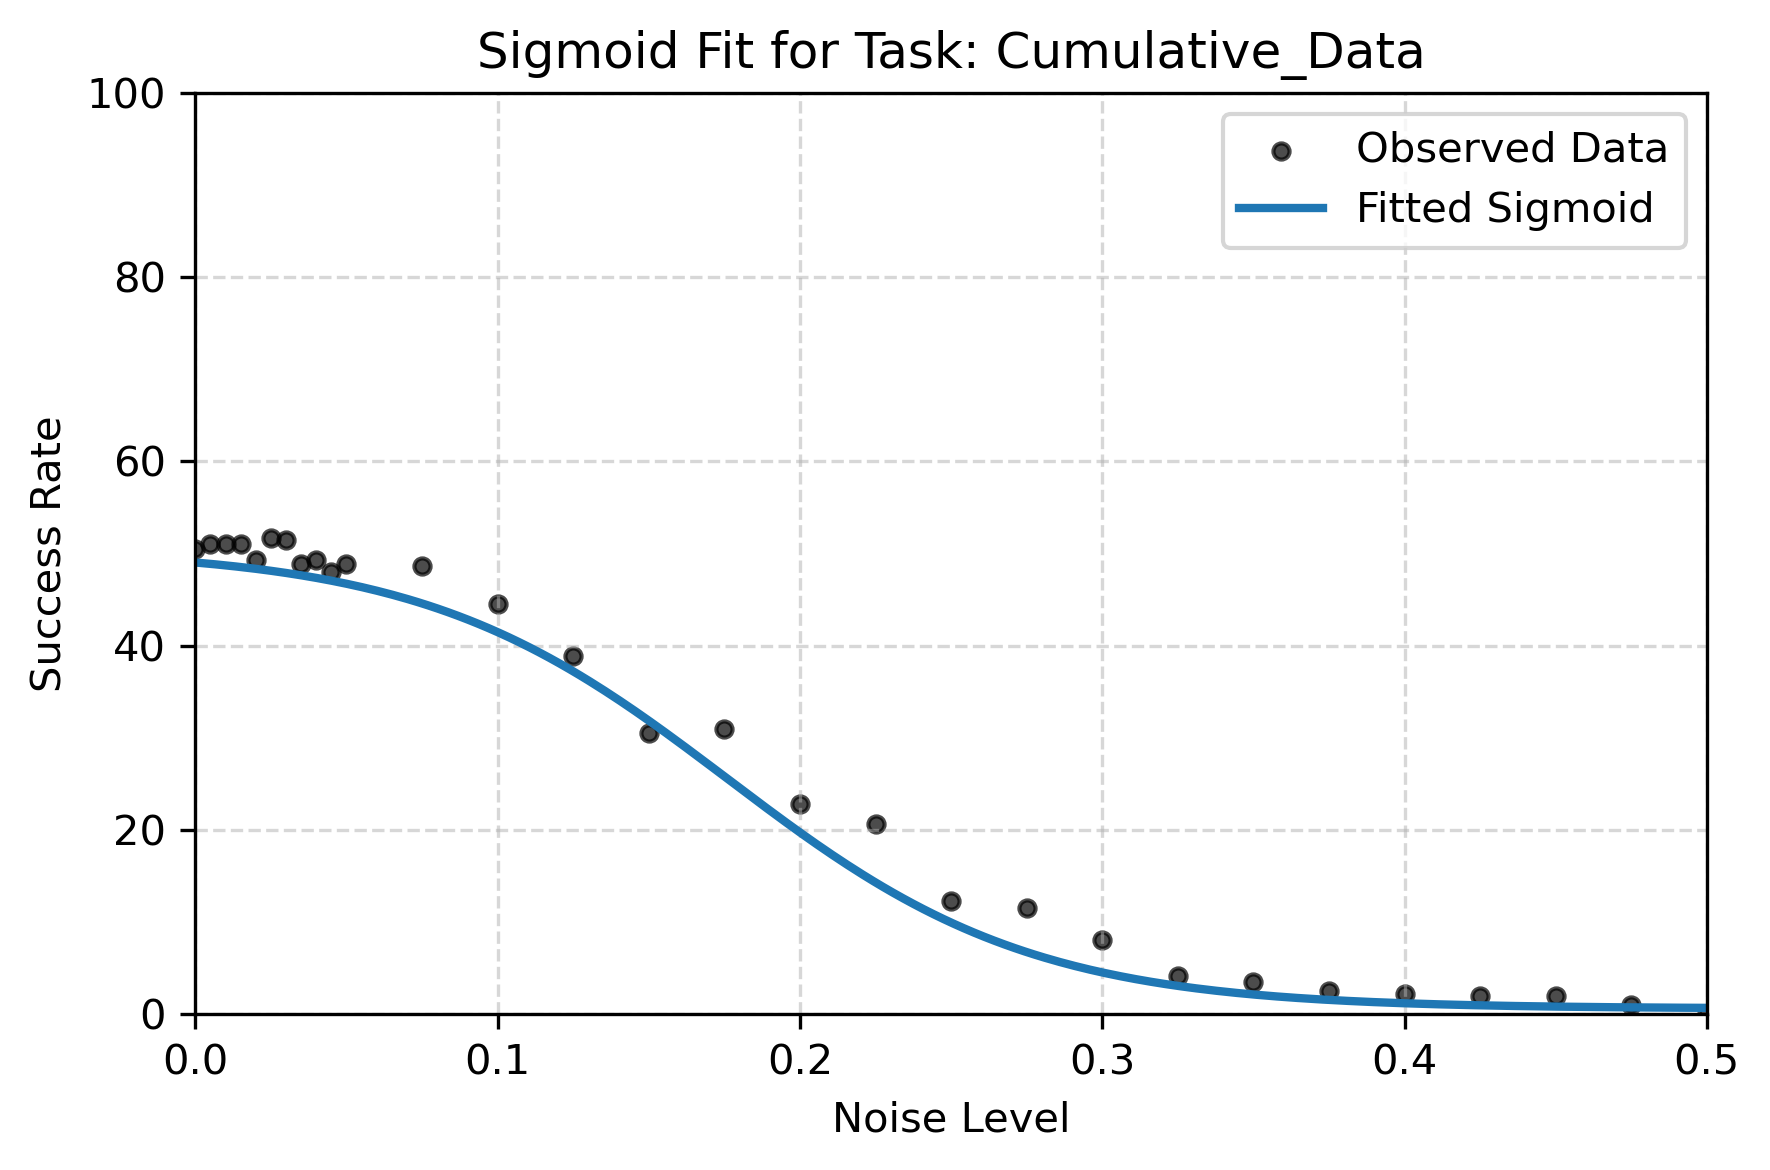

In [303]:
for task in tasks:
    data_dir = os.path.expanduser("~/MimicGenProject/MimicGenProject/data")
    output_csv = os.path.join(data_dir, f"{task}.csv")
    data = pd.read_csv(output_csv)
    data = data[data["noise"] < 1.0]

    # Your data
    x_data = data["noise"].to_numpy()
    y_data = data["success_rate"].to_numpy() if task != "Cumulative_Data" else data["avg accuracy"].to_numpy()

    P = y_data[0]
    Q = y_data[18] # 0.25 noise level

    # Your sigmoid function
    custom_sigmoid = fit_parameter_models_2D(learned_parameters)
    
    # Sigmoid Evaluation
    sigmoid_eval = custom_sigmoid(x_data, P, Q)

    # print(f"Parameters for task {task}: {str(params_opt)}")
    # print(f"Performance with 0 noise: {y_data[0]}")
    SSE = np.sum((y_data - sigmoid_eval)**2)
    print(f"SSE: {SSE}")
    # Put the SSE in the summary_statistics DataFrame
    summary_statistics.loc[task, 'SSE2'] = SSE
    # Add RMSE and MAE to summary_statistics
    RMSE = np.sqrt(SSE / len(x_data))
    MAE = np.mean(np.abs(y_data - sigmoid_eval))
    summary_statistics.loc[task, 'RMSE2'] = RMSE
    summary_statistics.loc[task, 'MAE2'] = MAE
    # Add R^2 to summary_statistics
    y_mean = np.mean(y_data)
    SS_total = np.sum((y_data - y_mean)**2)
    SS_residual = np.sum((y_data - sigmoid_eval)**2)
    R_squared = 1 - (SS_residual / SS_total)
    summary_statistics.loc[task, 'R_squared2'] = R_squared
    
    if MAKE_GRAPHS_B:
        # Plot
        plt.figure(figsize=(6, 4), dpi=300)
        plt.scatter(x_data, y_data, label='Observed Data', color='black', s=15, alpha=0.7)

        x_fit = np.linspace(min(x_data), max(x_data), 300)
        y_fit = custom_sigmoid(x_fit, P, Q)
        plt.plot(x_fit, y_fit, label='Fitted Sigmoid', linewidth=2)

        # Labels and styling
        plt.title(f"Sigmoid Fit for Task: {task}", fontsize=12)
        plt.xlabel("Noise Level", fontsize=10)
        plt.ylabel("Success Rate", fontsize=10)
        plt.ylim(0,100)
        plt.xlim(0,.5)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()

        # Optional: save figure
        # fig_path = os.path.join(data_dir, f"{task}_fit.png")
        # plt.savefig(fig_path, dpi=300)
        if SAVE_FILE:
            plt.savefig(os.path.join(data_dir, f"charts/approx_sigmoid/{task}_fit.png"), dpi=300)
        plt.show()

In [304]:
statistics = summary_statistics.copy()
trial_count = 30
# Display summary statistics
print("Summary Statistics:")
print(statistics)

Summary Statistics:
                               SSE1         SSE2     RMSE1      MAE1  \
square_D1                267.622802   414.988895  3.037824  2.366566   
nut_assembly_D0          279.670012   477.459188  3.105446  2.304336   
three_piece_assembly_D1  145.067728   369.075913  2.236590  1.702745   
kitchen_D1               361.906033   809.749729  3.532636  2.373988   
coffee_D1                354.325808   402.176354  3.495444  2.602976   
stack_three_D1           336.957914   507.365377  3.408700  2.873784   
stack_D0                 183.951226  1427.502584  2.518560  1.704060   
hammer_cleanup_D0         51.384912   483.708226  1.331125  0.987178   
pick_place_D0            264.116067   559.993704  3.017855  1.967556   
coffee_preparation_D1    113.672166   275.361805  1.979831  1.372731   
mug_cleanup_D1           122.492911   331.286926  2.055211  1.568760   
threading_D2             128.468068   165.968351  2.104741  1.456025   
Cumulative_Data           48.070585   210.71